In [1]:
import time
import random
import numpy as np
import importlib

import sys
sys.path.append("../../")

In [2]:
from qiskit import QuantumProgram
import Qconfig

In [3]:
import tools.Experiment_tools as exptool
import tools.Ploting_tools as plottool

In [24]:
importlib.reload(exptool)
importlib.reload(plottool)

<module 'tools.Ploting_tools' from '/Users/cvuillot/WorkSync/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Ploting_tools.py'>

In [5]:
qprogram = QuantumProgram()
qprogram.set_api(Qconfig.APItoken, Qconfig.config["url"])

In [6]:
api = qprogram.get_api()

In [7]:
qprogram.available_backends()

['ibmqx4',
 'ibmqx5',
 'ibmqx2',
 'ibmqx_qasm_simulator',
 'local_qasm_simulator',
 'local_unitary_simulator']

In [8]:
print(qprogram.get_backend_status("ibmqx4"))
api.get_my_credits()

{'available': True, 'busy': False, 'pending_jobs': 0, 'backend': 'ibmqx4'}


{'maxUserType': 150, 'promotional': 100, 'remaining': 150}

In [9]:
config = qprogram.get_backend_configuration("ibmqx2",list_format=True)
config

{'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': 'Sparrow',
 'coupling_map': [[0, 1], [0, 2], [1, 2], [3, 2], [3, 4], [4, 2]],
 'description': '5 transmon bowtie',
 'n_qubits': 5,
 'name': 'ibmqx2',
 'online_date': '2017-01-10T12:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx2',
 'version': '1'}

In [10]:
config = qprogram.get_backend_configuration("ibmqx5",list_format=True)
config

{'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': 'Albatross',
 'coupling_map': [[1, 0],
  [1, 2],
  [2, 3],
  [3, 4],
  [3, 14],
  [5, 4],
  [6, 5],
  [6, 7],
  [6, 11],
  [7, 10],
  [8, 7],
  [9, 8],
  [9, 10],
  [11, 10],
  [12, 5],
  [12, 11],
  [12, 13],
  [13, 4],
  [13, 14],
  [15, 0],
  [15, 2],
  [15, 14]],
 'description': '16 transmon 2x8 ladder',
 'n_qubits': 16,
 'name': 'ibmqx5',
 'online_date': '2017-09-21T11:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx5',
 'version': '1'}

In [11]:
config = qprogram.get_backend_configuration("ibmqx4",list_format=True)
config

{'basis_gates': 'SU2+CNOT',
 'chip_name': 'Raven',
 'coupling_map': [[1, 0], [2, 0], [2, 1], [2, 4], [3, 2], [3, 4]],
 'description': '5 qubit transmon bowtie chip 3',
 'n_qubits': 5,
 'name': 'ibmqx4',
 'online_date': '2017-09-18T11:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx4',
 'version': '1'}

In [12]:
n = config['n_qubits']
q = qprogram.create_quantum_register("q",n)
c = qprogram.create_classical_register("c",n)

In [18]:
circuit_names = exptool.all_circuits(qprogram,config['coupling_map'])
circuit_names_nftv2 = [name for name in circuit_names if 'nftv2' in name]
circuit_names_nftv2 = circuit_names_nftv2 + circuit_names_nftv2 + circuit_names_nftv2 + circuit_names_nftv2

In [160]:
rand_perm_names = np.random.permutation(circuit_names)
batches = [list(rand_perm_names[50*j:50*(j+1)]) for j in range(0,1+int(len(circuit_names)/50))]
compiled_qobj_list = [qprogram.compile(batch, 
                                       backend='ibmqx4', 
                                       config=None,
                                       silent=False, 
                                       basis_gates=None, 
                                       coupling_map=None, 
                                       initial_layout=None, 
                                       shots=8192, 
                                       max_credits=5, 
                                       seed=None) for batch in batches]

In [161]:
qprogram.run_batch_async(compiled_qobj_list, wait=2, timeout=6, silent=True, callback=exptool.post_treatment_list)

In [128]:
for j in range(0,0):
    rand_perm_names_nftv2 = np.random.permutation(circuit_names_nftv2)




    compiled_qobj_list_nftv2 = [qprogram.compile(list(rand_perm_names_nftv2), 
                                       backend='ibmqx4', 
                                       config=None,
                                       silent=False, 
                                       basis_gates=None, 
                                       coupling_map=None, 
                                       initial_layout=None, 
                                       shots=8192, 
                                       max_credits=5, 
                                       seed=None)]

    qprogram.run_batch_async(compiled_qobj_list_nftv2, wait=2, timeout=6, silent=True, callback=exptool.post_treatment_list_verif_nftv2)

In [166]:
print(qprogram.get_backend_status("ibmqx4"))
api.get_my_credits()

{'available': True, 'busy': False, 'pending_jobs': 138, 'backend': 'ibmqx4'}


{'maxUserType': 150, 'promotional': 100, 'remaining': 15}

In [164]:
print(exptool.fetch_previous('timed_out.txt',api))
print(exptool.fetch_previous('completed.txt',api))
print(exptool.fetch_previous_verif_nftv2('timed_out_verif_nftv2.txt',api))

0
0
1


In [67]:
dict_cn = exptool.get_qasm_name_dict(compiled_qobj_list)

In [165]:
print(exptool.process_all_api_dumps('data/completed_timed_out.txt','data/already_processed.txt',dict_cn))
print(exptool.process_all_api_dumps('data/completed_completed.txt','data/already_processed.txt',dict_cn))
print(exptool.process_all_api_dumps('data/completed_timed_out_old.txt','data/already_processed.txt',dict_cn))
print(exptool.process_all_api_dumps_verif_nftv2('data/completed_timed_out_verif_nftv2.txt','data/already_processed_verif_nftv2.txt',dict_cn))

0
0
0
1


In [92]:
importlib.reload(exptool)
importlib.reload(plottool)
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [70]:
#exptool.plot_everything_raw('data/Processed_data/')

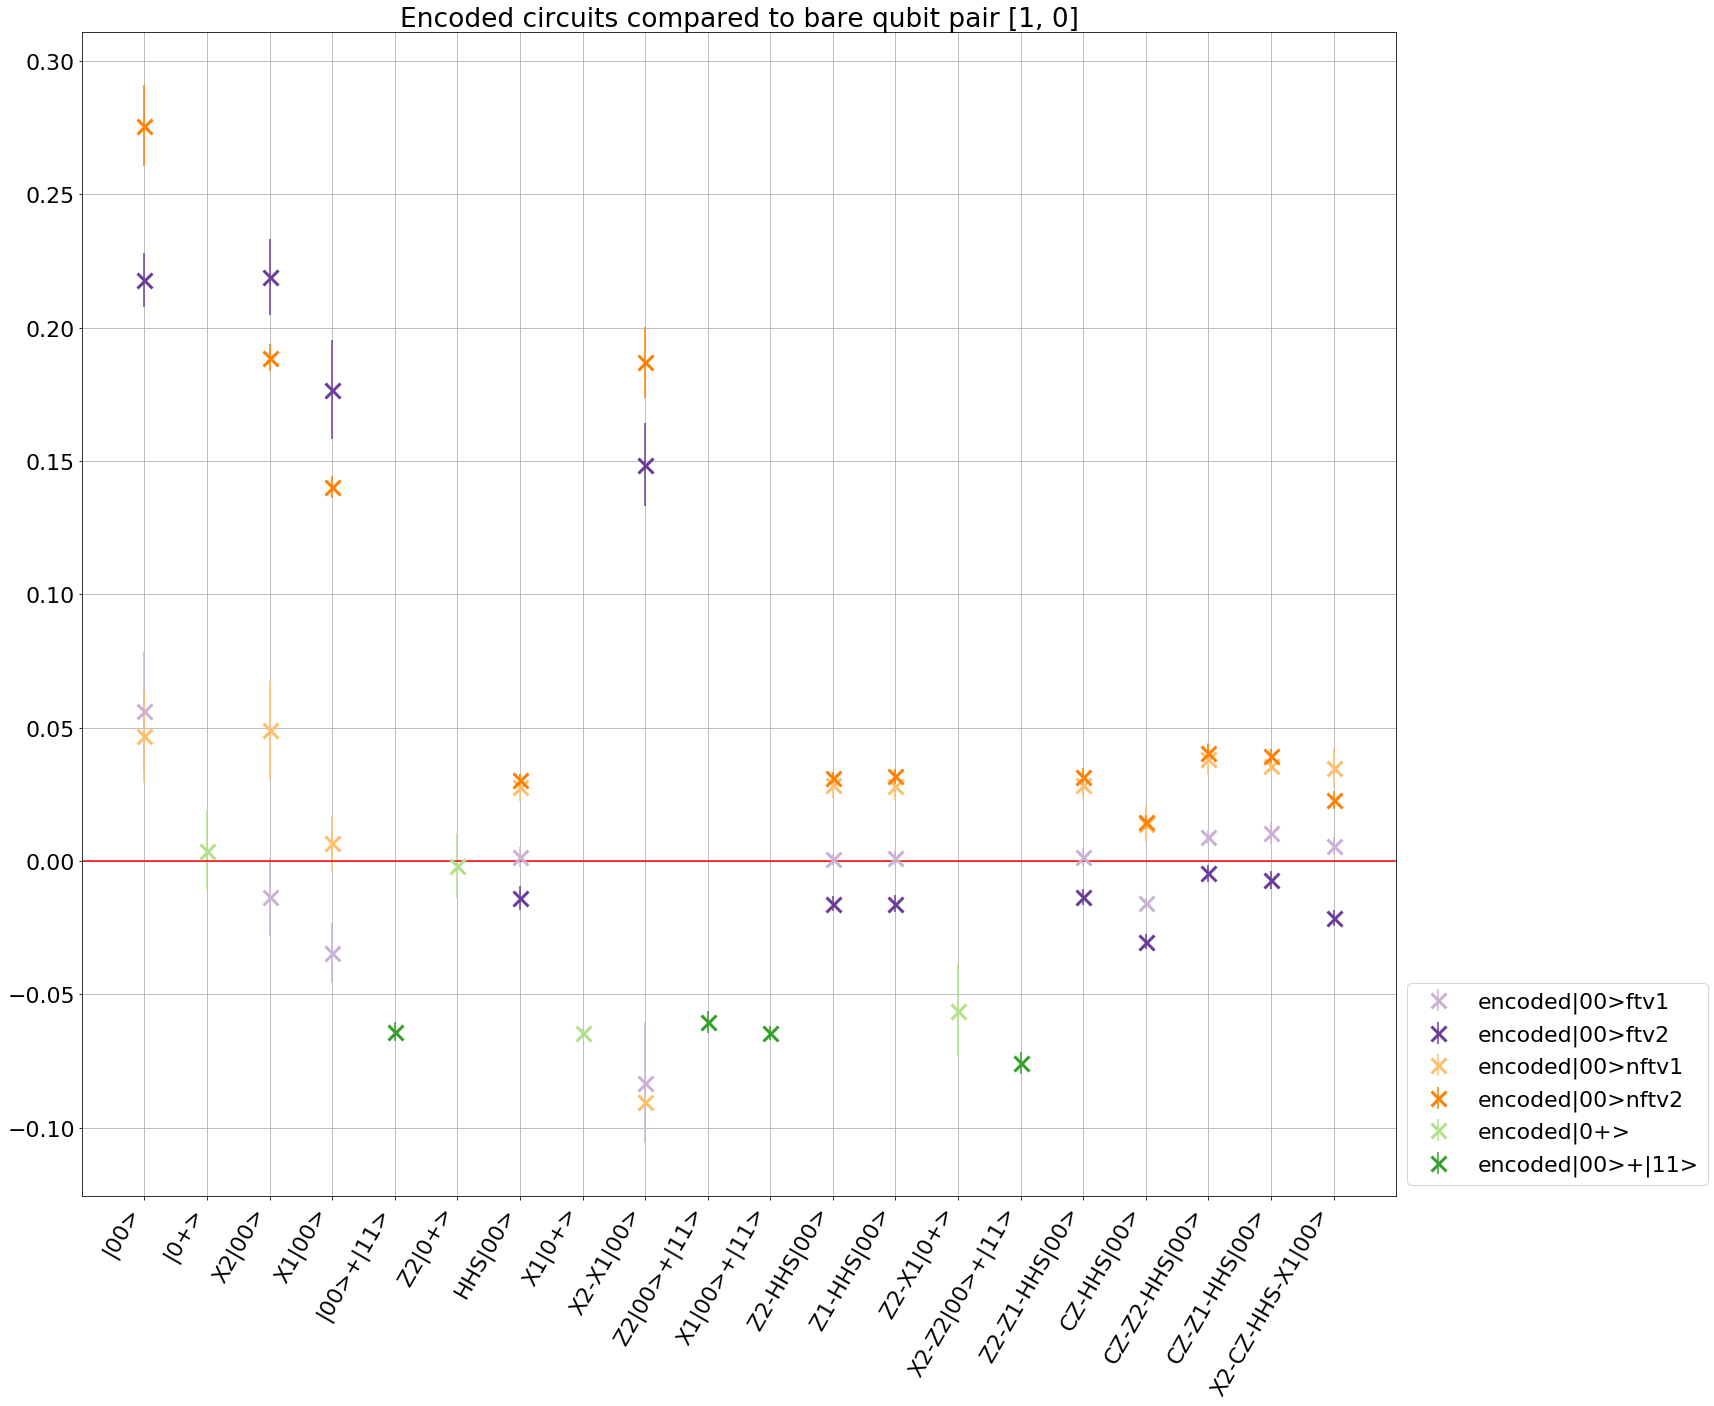

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998
encoded|00>ftv1 -0.005037053221274681
encoded|00>ftv2 0.0533187744393378
encoded|00>nftv1 0.02067758882668912
encoded|00>nftv2 0.08619325798167579
encoded|0+> -0.02953277162089072
encoded|00>+|11> -0.066105092960456


In [164]:
plottool.plot_everything_averaged_diff('data/Processed_data/', save_data_folder_pref='data/Plot_data/',
                                 logscaley=False,
                                 bareindex=0,
                                 ci=.99)

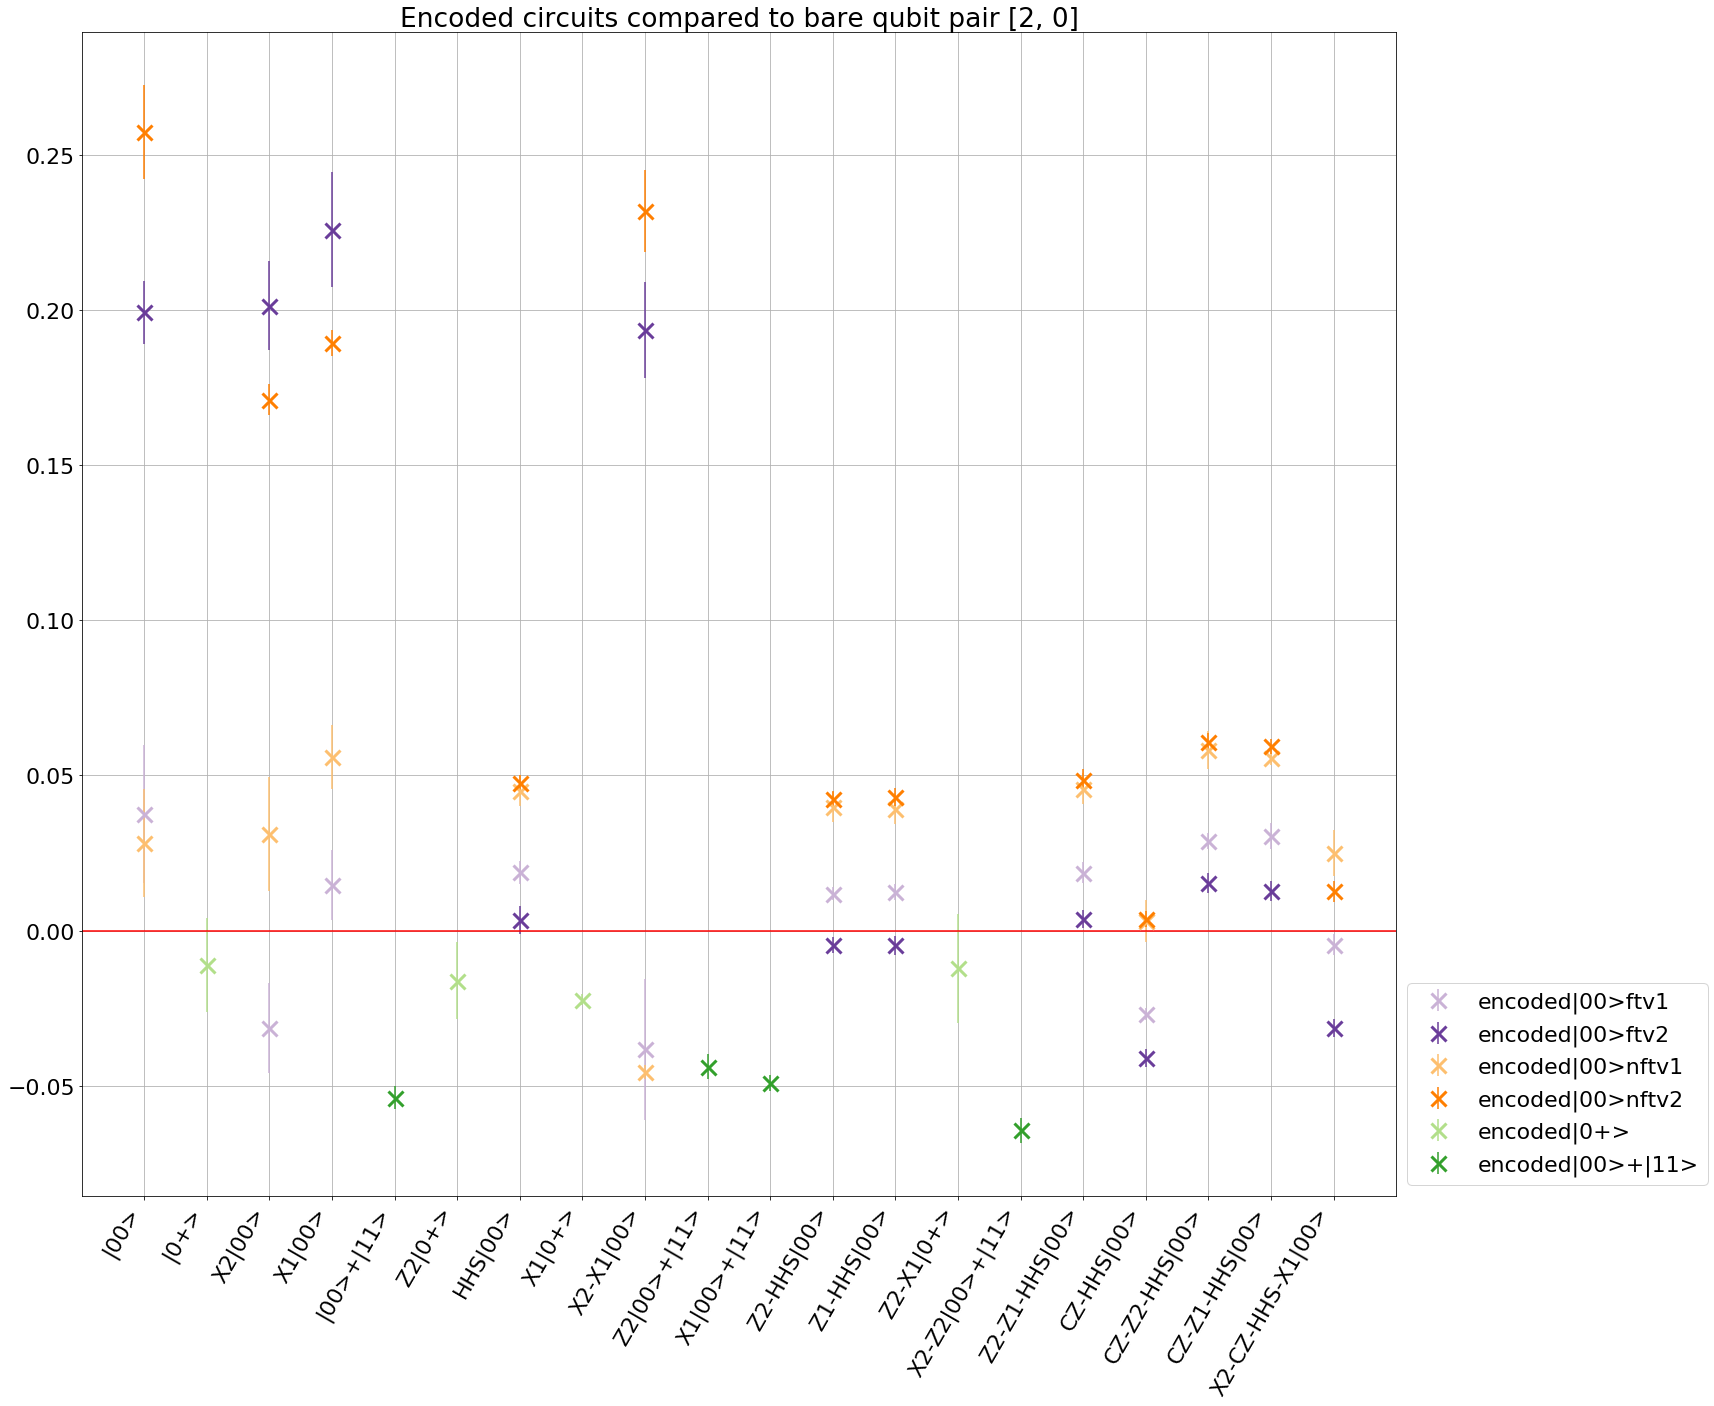

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998
encoded|00>ftv1 0.006099381473718689
encoded|00>ftv2 0.06445520913433117
encoded|00>nftv1 0.03181402352168249
encoded|00>nftv2 0.09732969267666916
encoded|0+> -0.015373624221201868
encoded|00>+|11> -0.05276537040107603


In [165]:
plottool.plot_everything_averaged_diff('data/Processed_data/', save_data_folder_pref='data/Plot_data/',
                                 logscaley=False,
                                 bareindex=1,
                                 ci=.99)

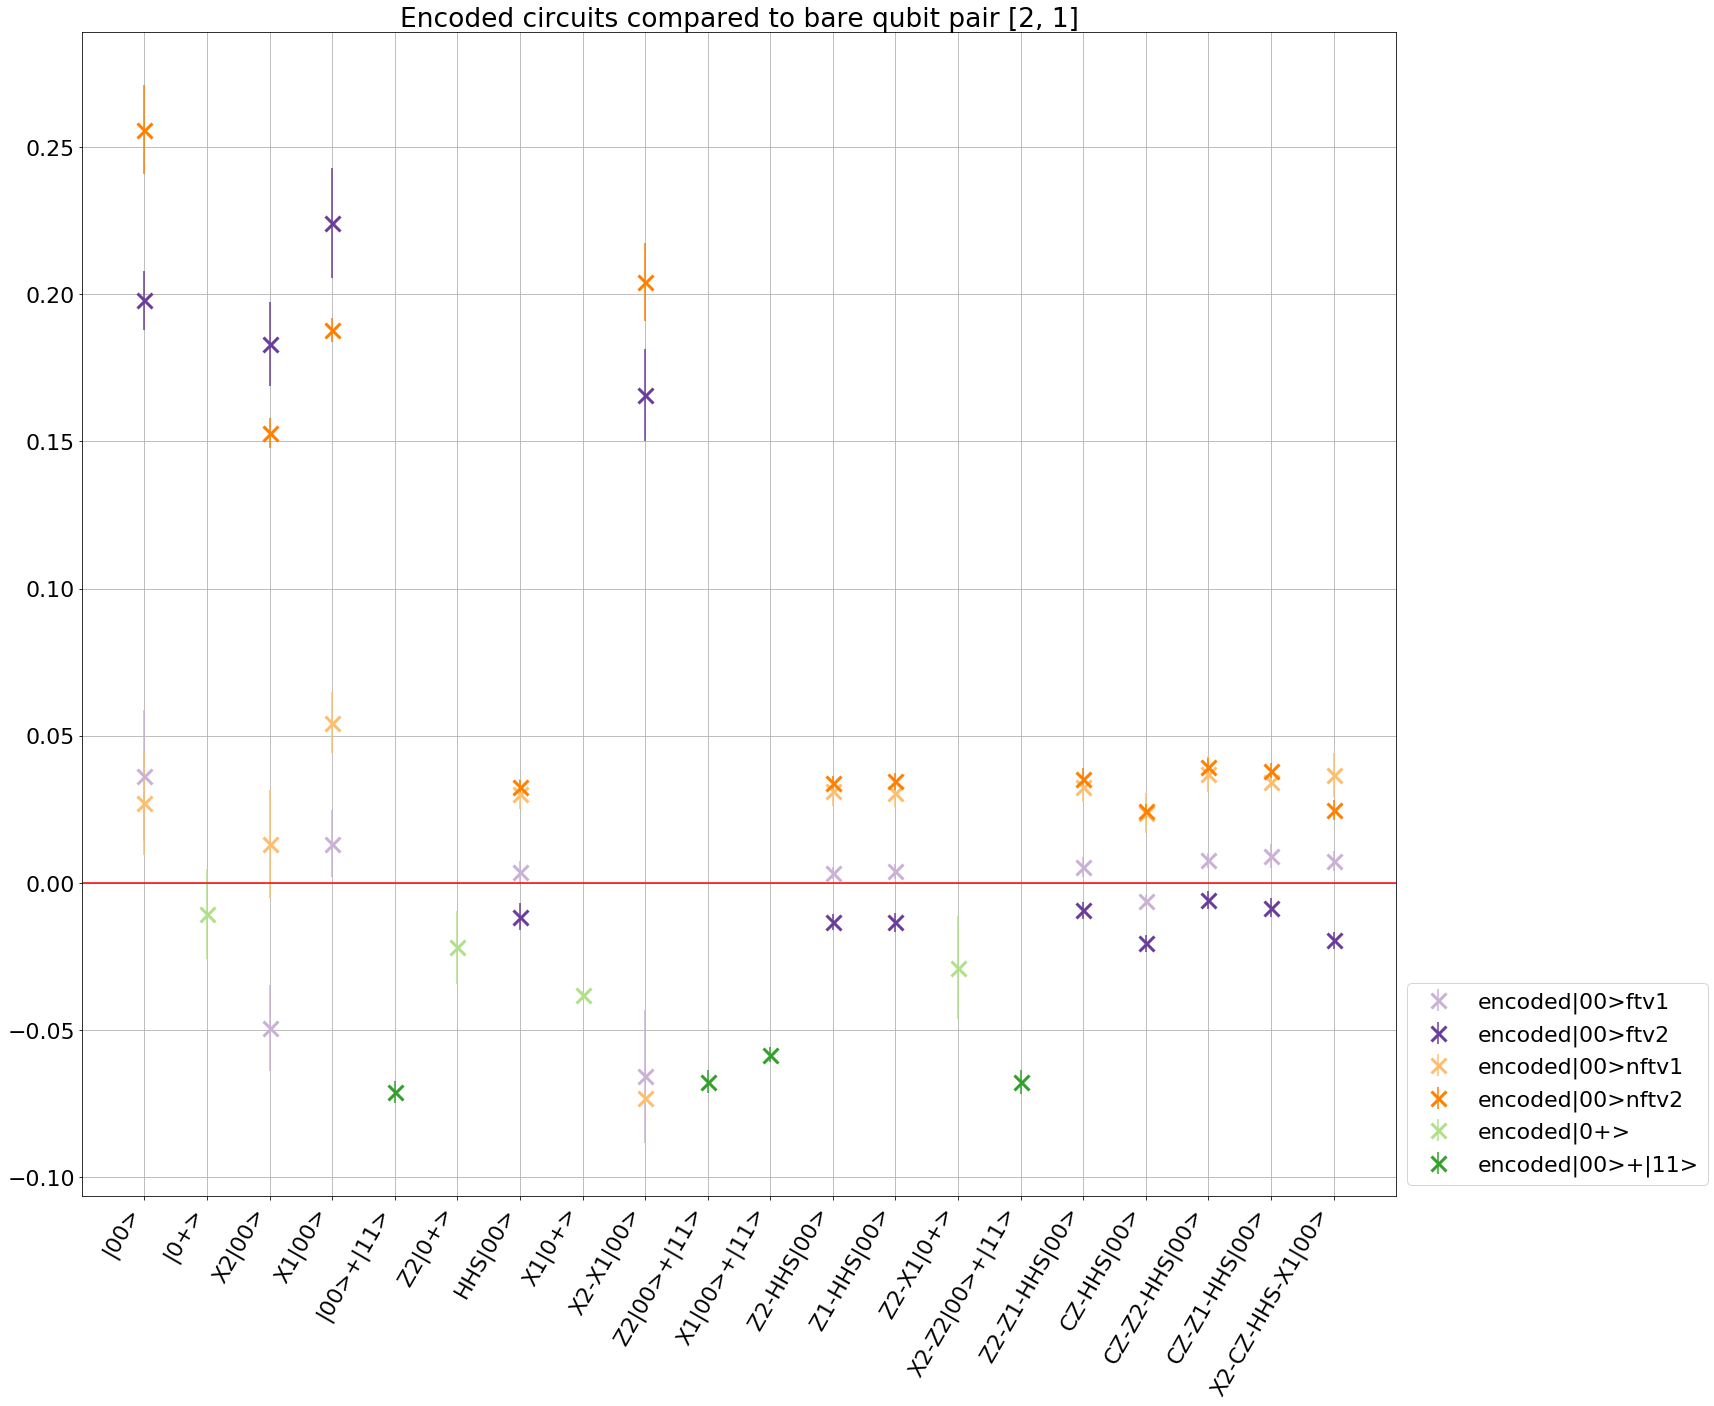

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998
encoded|00>ftv1 -0.0026198753979988394
encoded|00>ftv2 0.05573595226261365
encoded|00>nftv1 0.023094766649964963
encoded|00>nftv2 0.08861043580495163
encoded|0+> -0.02496159432829822
encoded|00>+|11> -0.06630571044219695


In [166]:
plottool.plot_everything_averaged_diff('data/Processed_data/', save_data_folder_pref='data/Plot_data/',
                                 logscaley=False,
                                 bareindex=2,
                                 ci=.99)

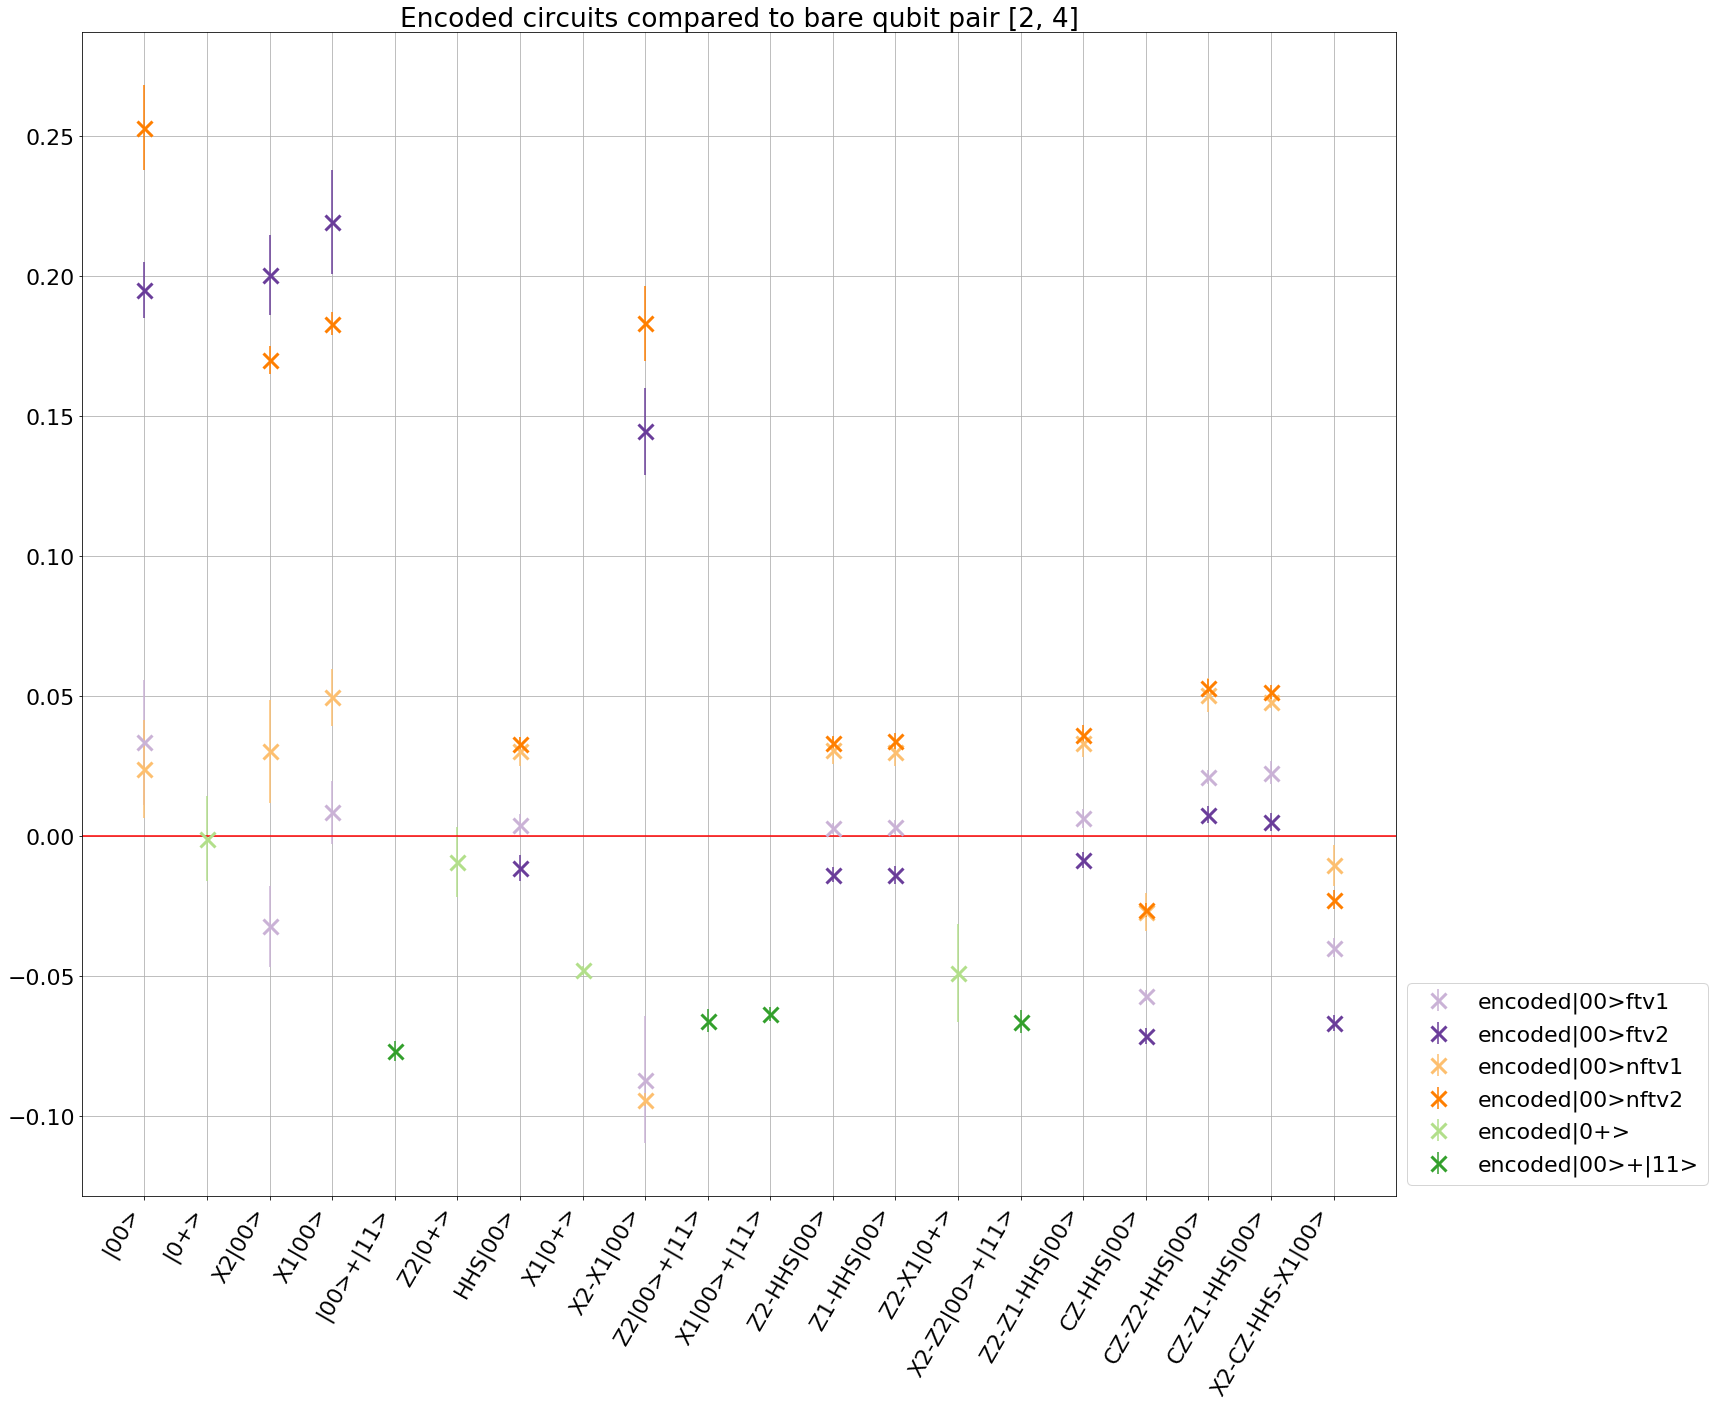

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998
encoded|00>ftv1 -0.009584235351763861
encoded|00>ftv2 0.04877159230884862
encoded|00>nftv1 0.01613040669619994
encoded|00>nftv2 0.08164607585118662
encoded|0+> -0.02688877160483301
encoded|00>+|11> -0.0682587638926627


In [167]:
plottool.plot_everything_averaged_diff('data/Processed_data/', save_data_folder_pref='data/Plot_data/',
                                 logscaley=False,
                                 bareindex=3,
                                 ci=.99)

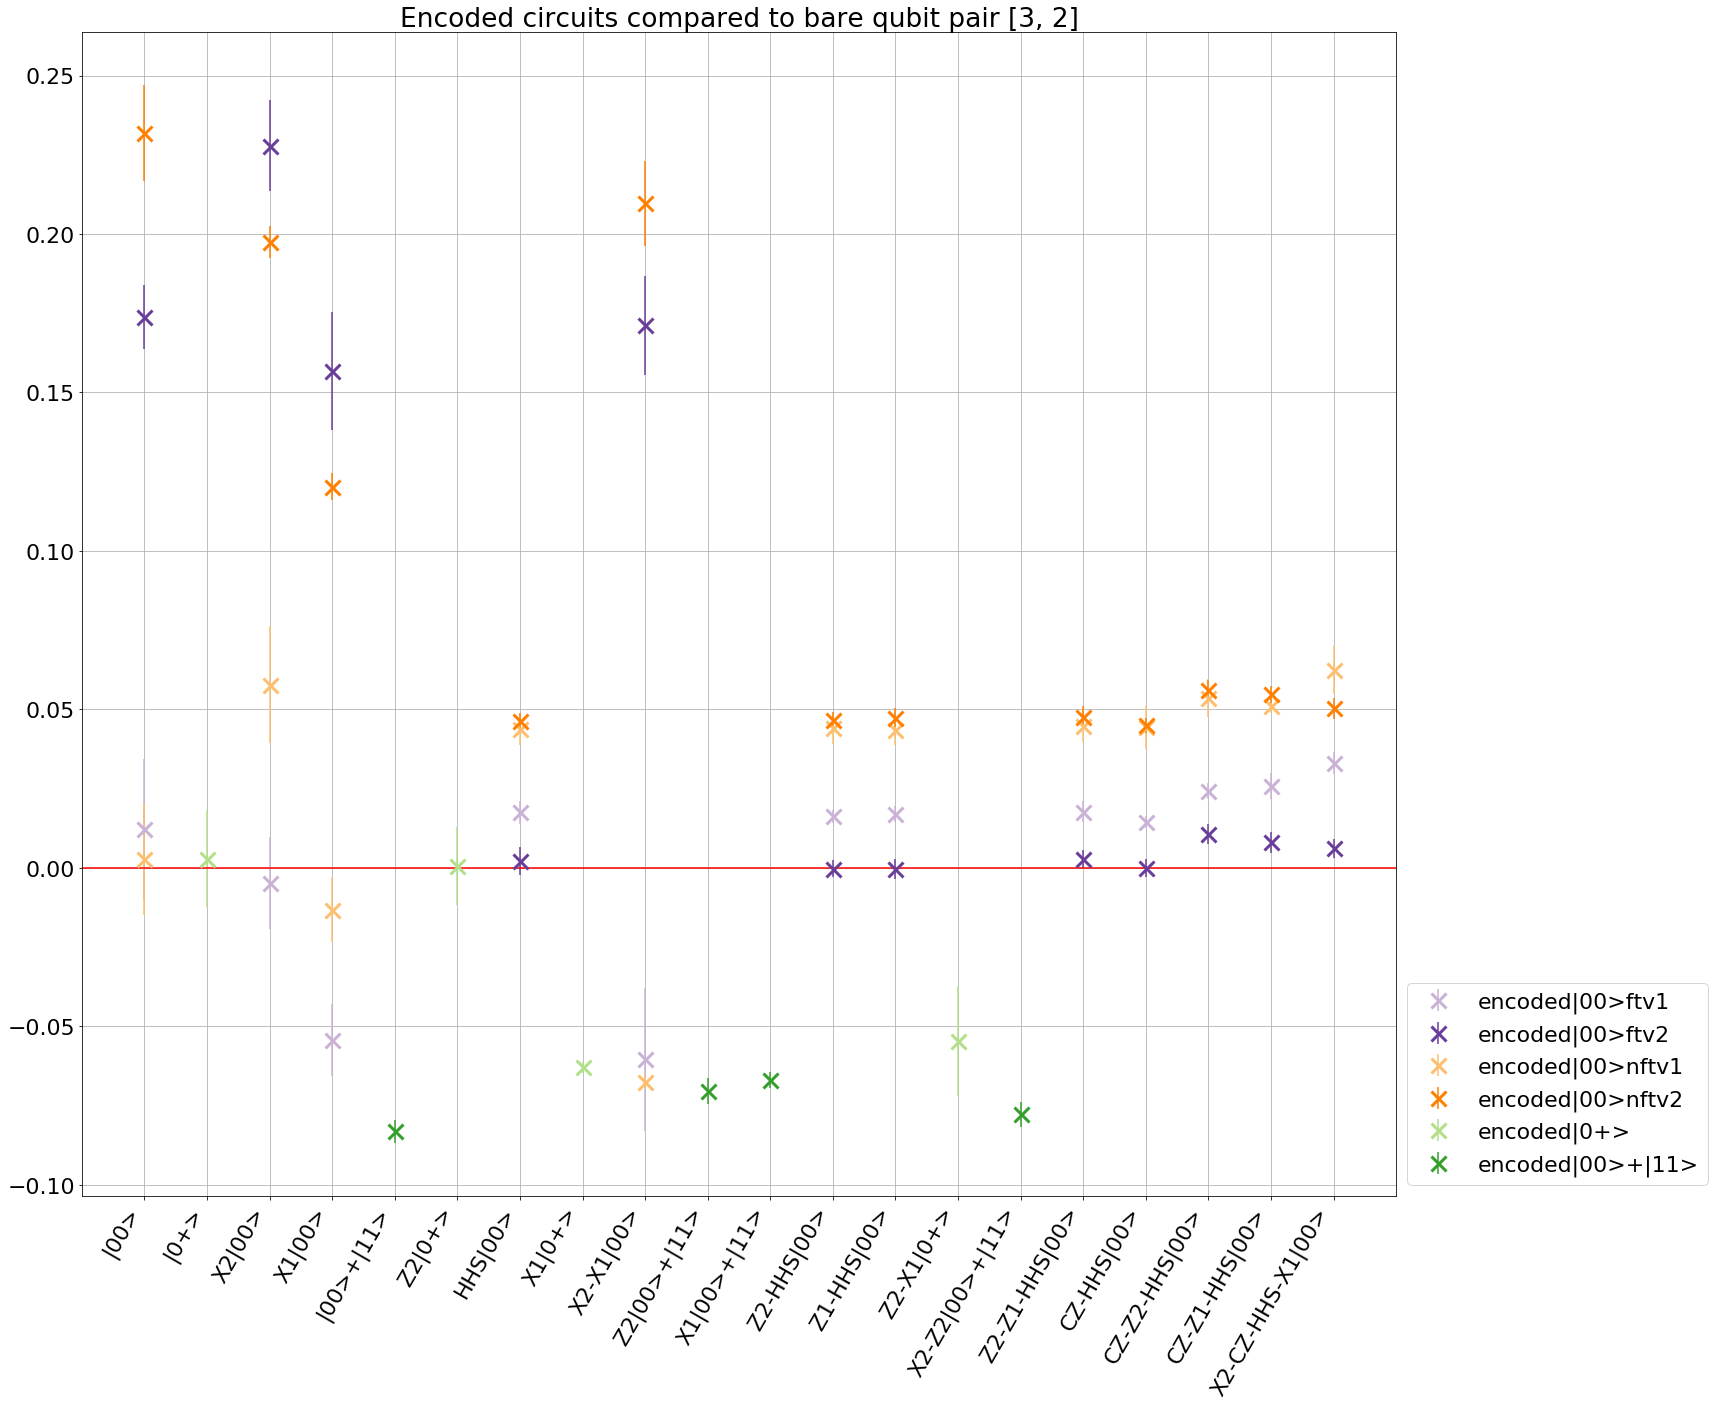

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998
encoded|00>ftv1 0.004893846456058145
encoded|00>ftv2 0.06324967411667064
encoded|00>nftv1 0.030608488504021945
encoded|00>nftv2 0.09612415765900861
encoded|0+> -0.028490169580872186
encoded|00>+|11> -0.07451304587650193


In [168]:
plottool.plot_everything_averaged_diff('data/Processed_data/', save_data_folder_pref='data/Plot_data/',
                                 logscaley=False,
                                 bareindex=4,
                                 ci=.99)

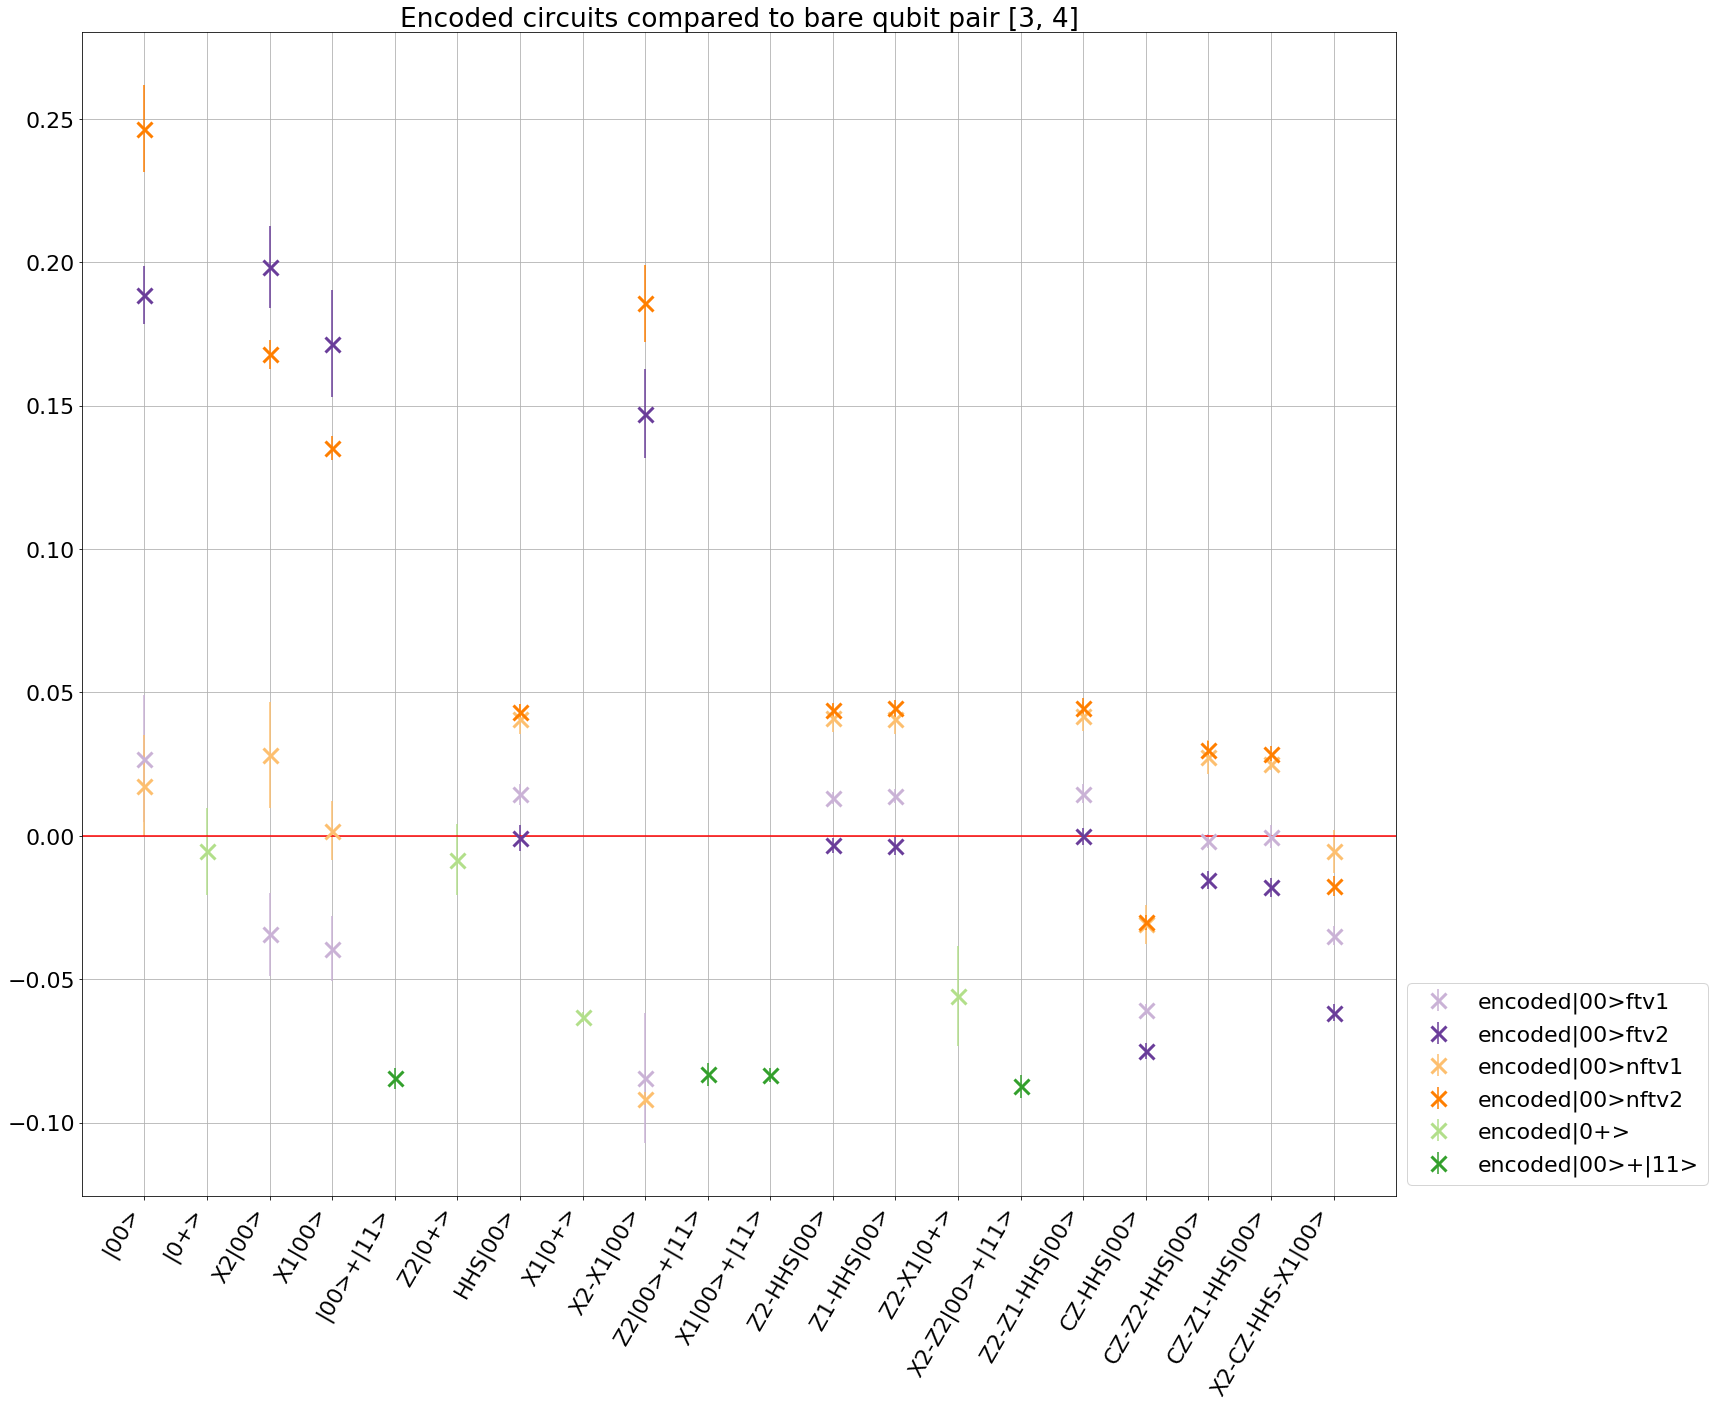

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998
encoded|00>ftv1 -0.014380936046398736
encoded|00>ftv2 0.04397489161421375
encoded|00>nftv1 0.011333706001565065
encoded|00>nftv2 0.07684937515655174
encoded|0+> -0.03317863858128181
encoded|00>+|11> -0.08463808249113808


In [169]:
plottool.plot_everything_averaged_diff('data/Processed_data/', save_data_folder_pref='data/Plot_data/',
                                 logscaley=False,
                                 bareindex=5,
                                 ci=.99)

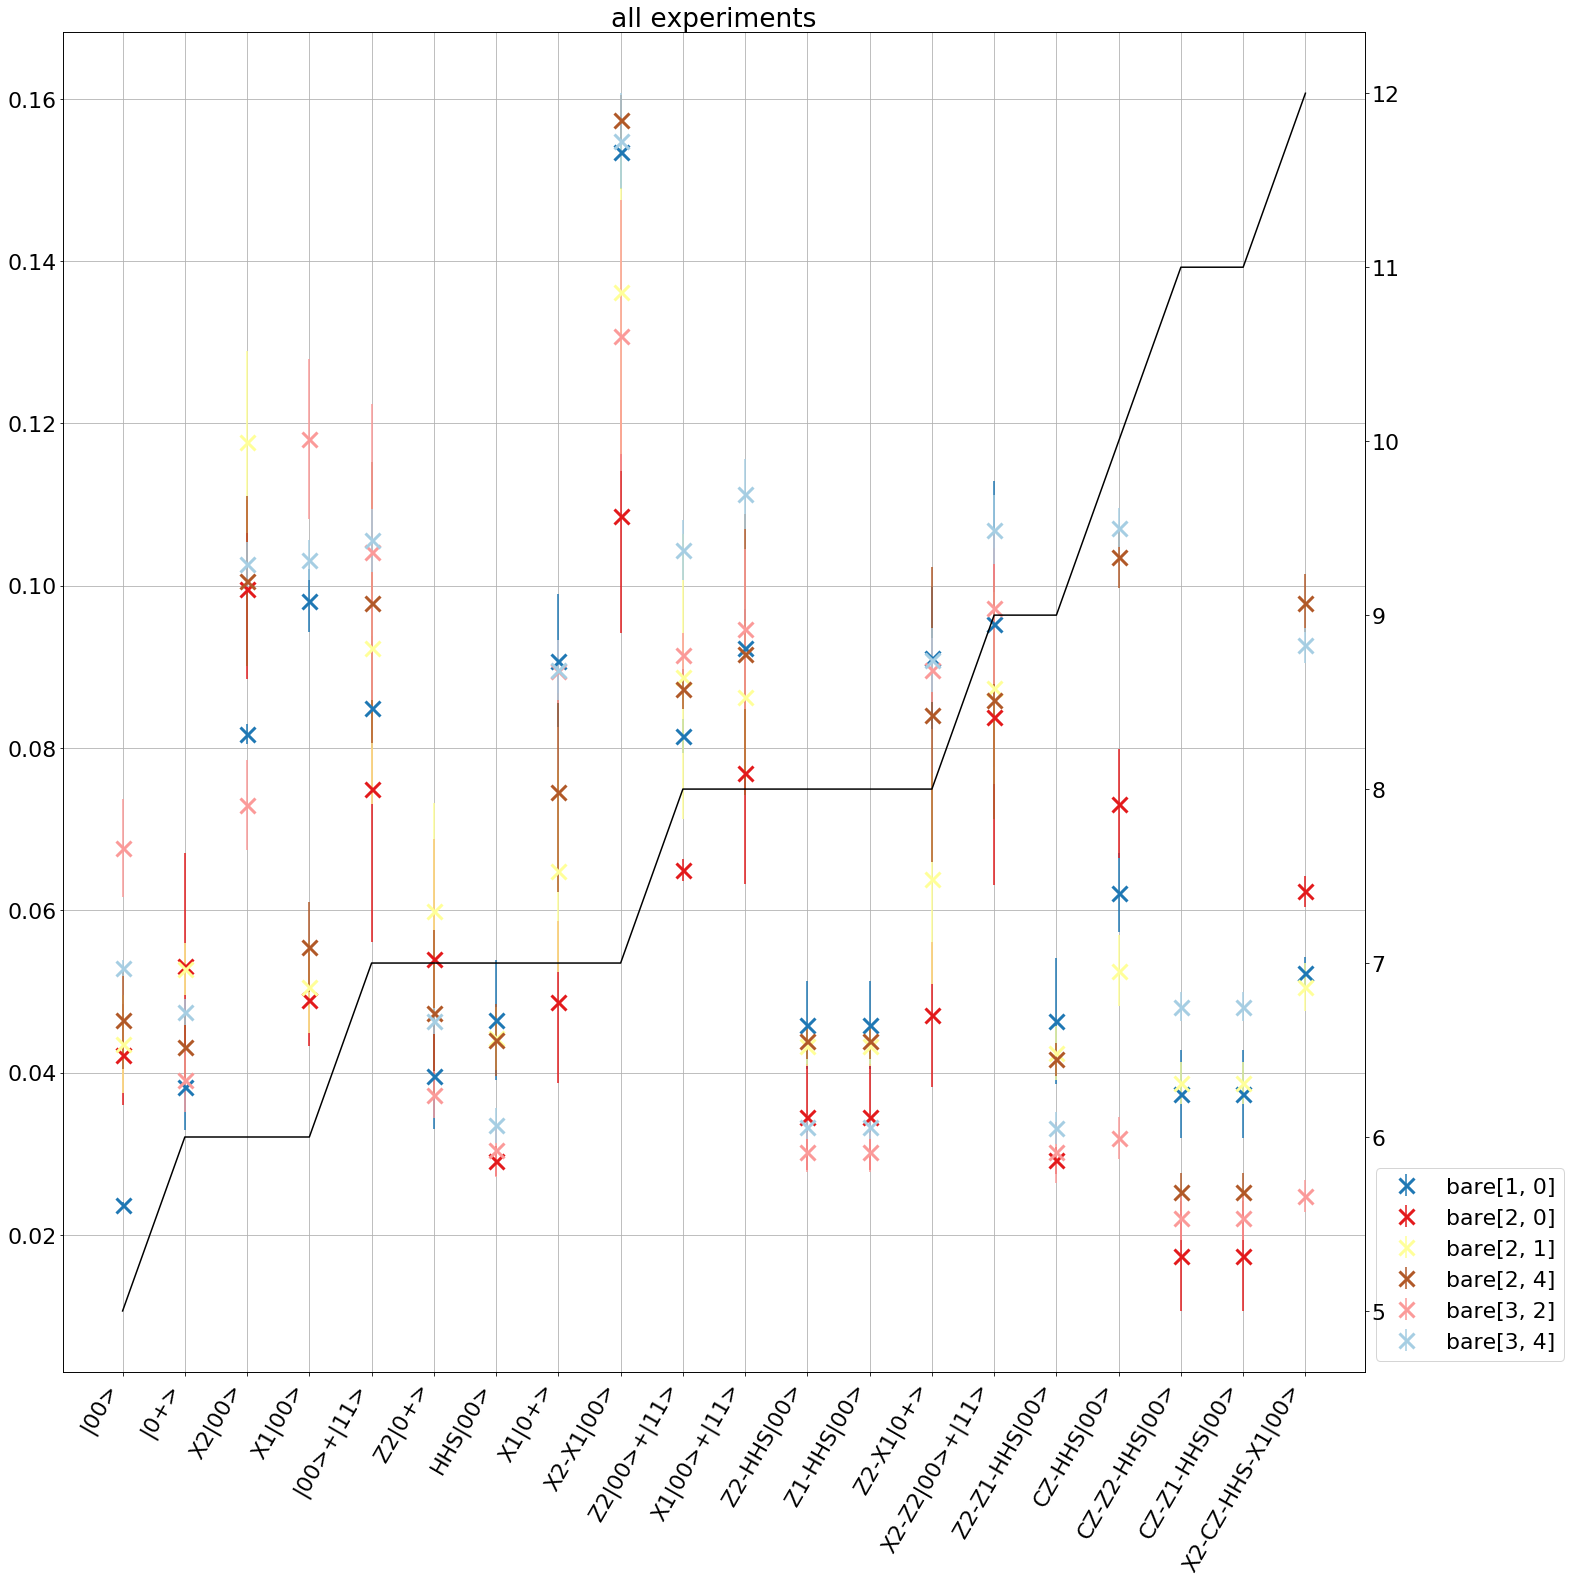

0 27398
bare[1, 0] 0.0672178879495609
bare[2, 0] 0.055036253140751126
bare[2, 1] 0.0648934692934251
bare[2, 4] 0.06984813141108422
bare[3, 2] 0.06273241831836669
bare[3, 4] 0.07725998894284998
encoded|00>ftv1 0.05585260583230345
encoded|00>ftv2 0.11420843349291593
encoded|00>nftv1 0.08156724788026726
encoded|00>nftv2 0.14708291703525392
encoded|0+> 0.035389089858050844
encoded|00>+|11> 0.0223935081476726


In [170]:
plottool.plot_everything_averaged('data/Processed_data/', save_data_folder_pref='data/Plot_data/',
                                 logscaley=False,
                                 sublabels=plottool.PLOT_LABELS[:6],
                                 ci=.99)

In [150]:
import os

In [117]:
importlib.reload(exptool)
importlib.reload(plottool)

<module 'tools.Ploting_tools' from '/Users/cvuillot/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Ploting_tools.py'>

In [152]:
file_list = os.listdir('data/Processed_data/')
n=0
for filename in file_list:
    n += exptool.repair_processed_data('data/Processed_data/'+filename, new_ext='')
print(n)

0


In [115]:
importlib.reload(exptool)
importlib.reload(plottool)

<module 'tools.Ploting_tools' from '/Users/cvuillot/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Ploting_tools.py'>

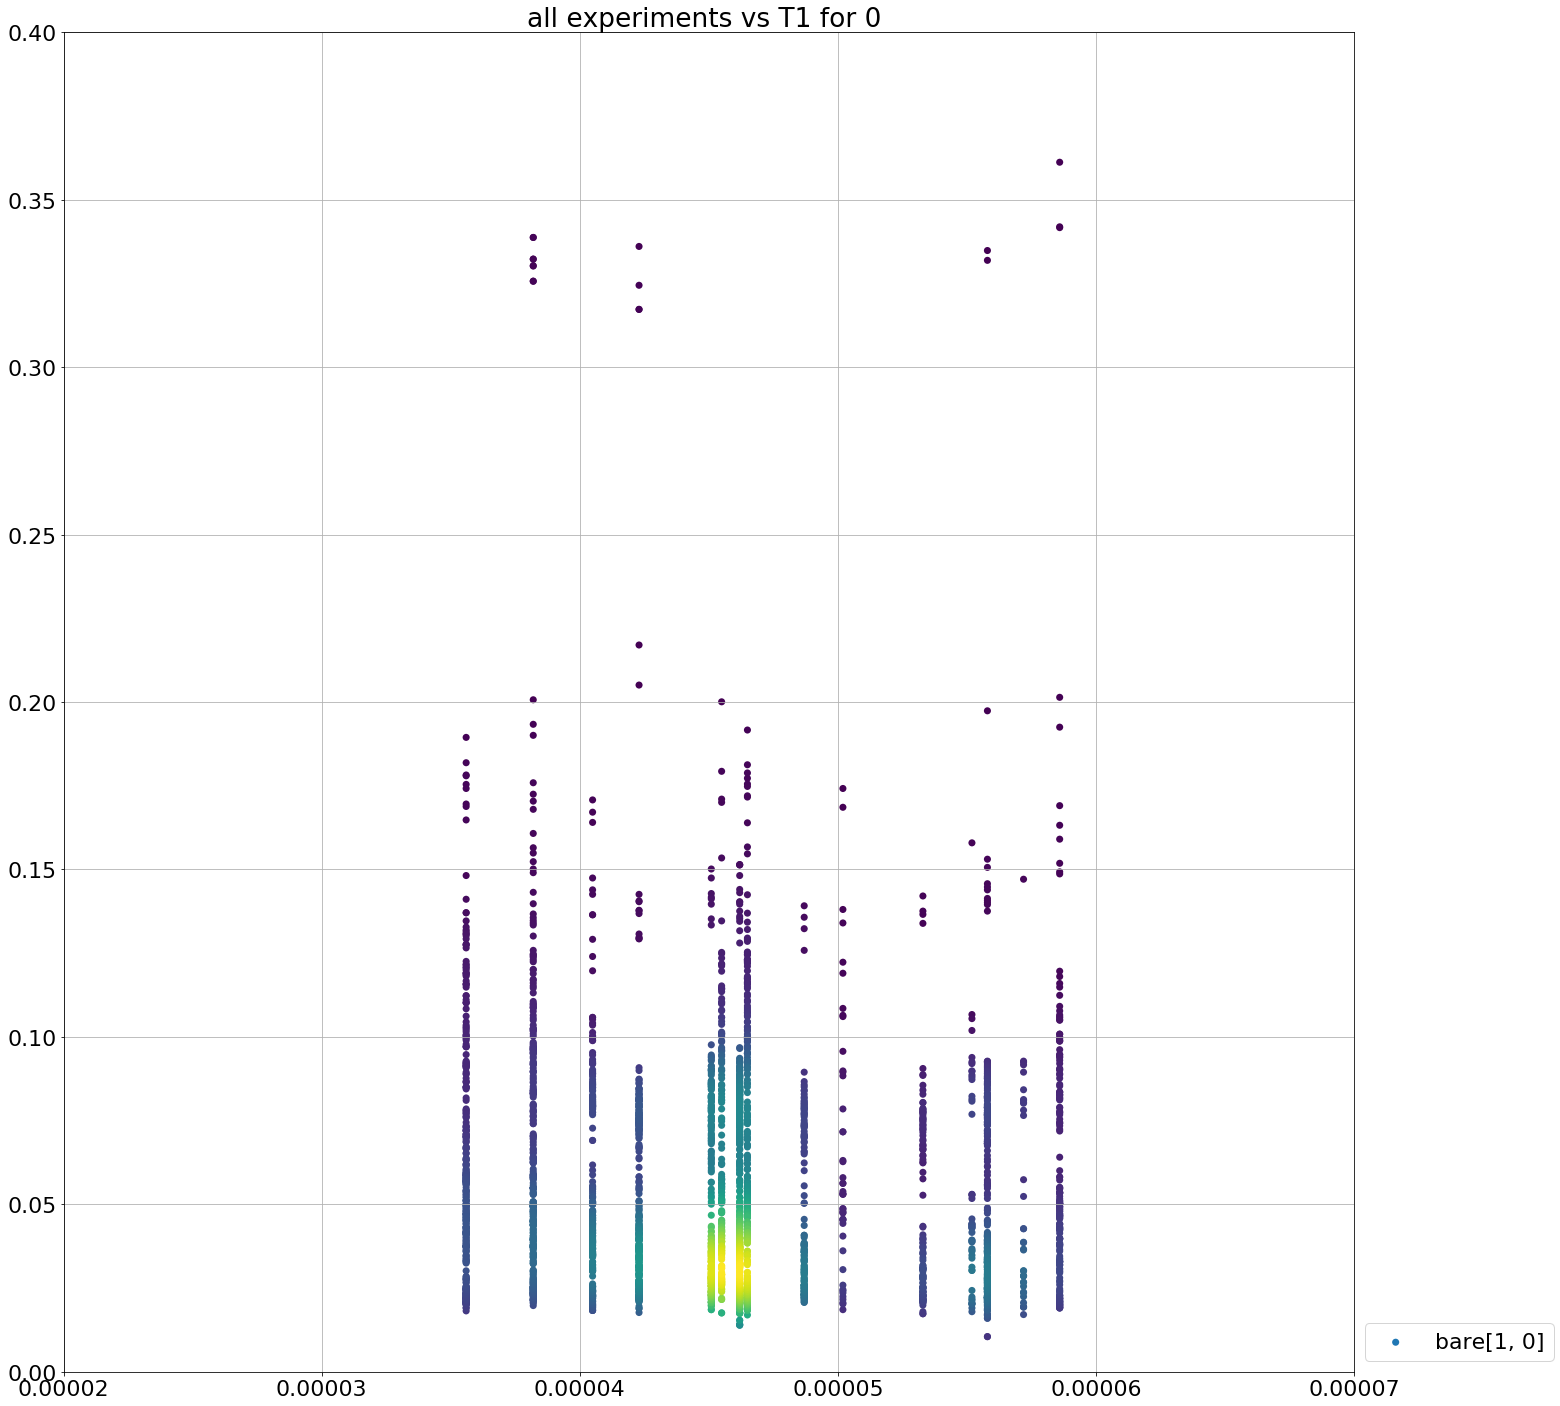

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [117]:
plottool.plot_everything_calib_data('data/Processed_data/', 0, 'T1',  
                                    logscalex=False, 
                                    logscaley=False, 
                                    y_range=[0,0.4], 
                                    x_range=[0.00002,0.00007], 
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [0]])

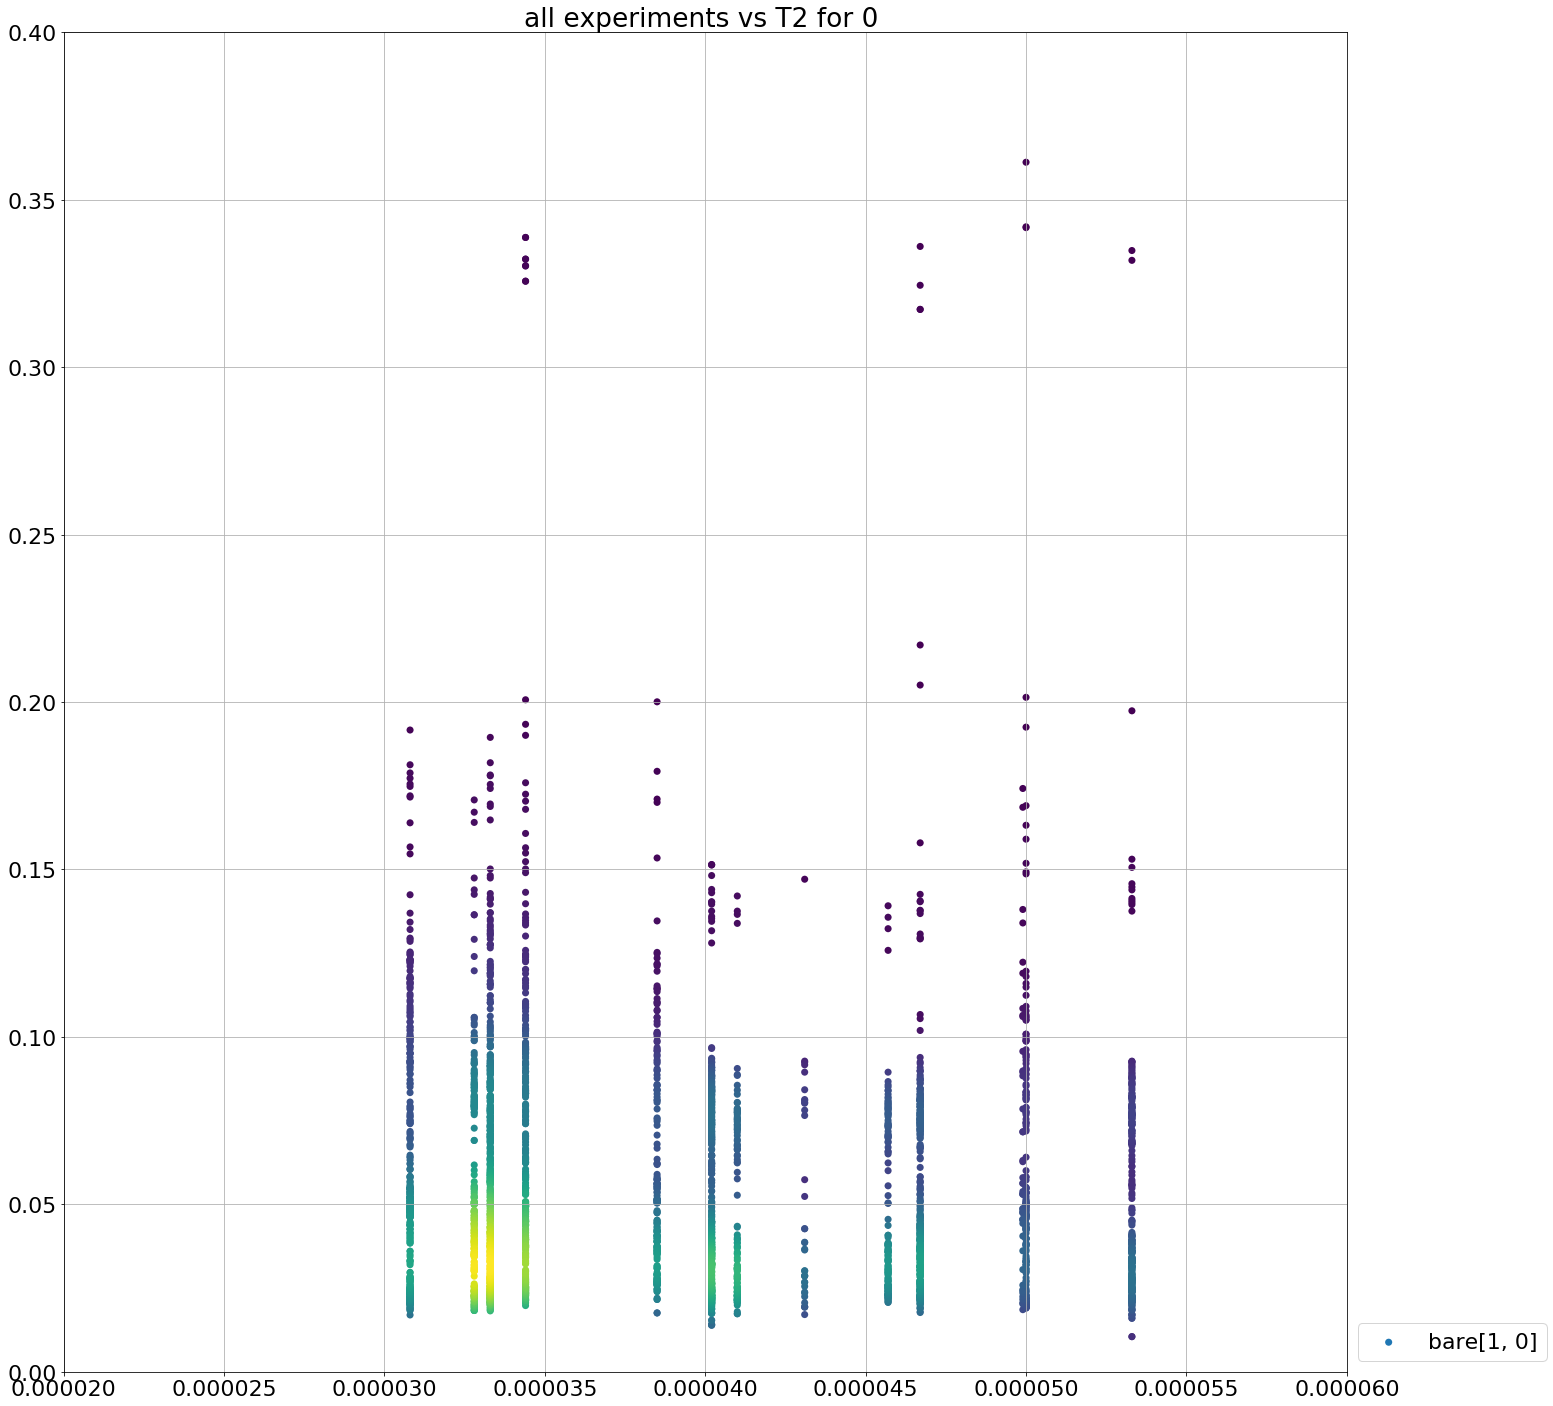

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [91]:
plottool.plot_everything_calib_data('data/Processed_data/', 0, 'T2', 
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.00002,0.00006],
                                    y_range=[0,0.4],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [0]])

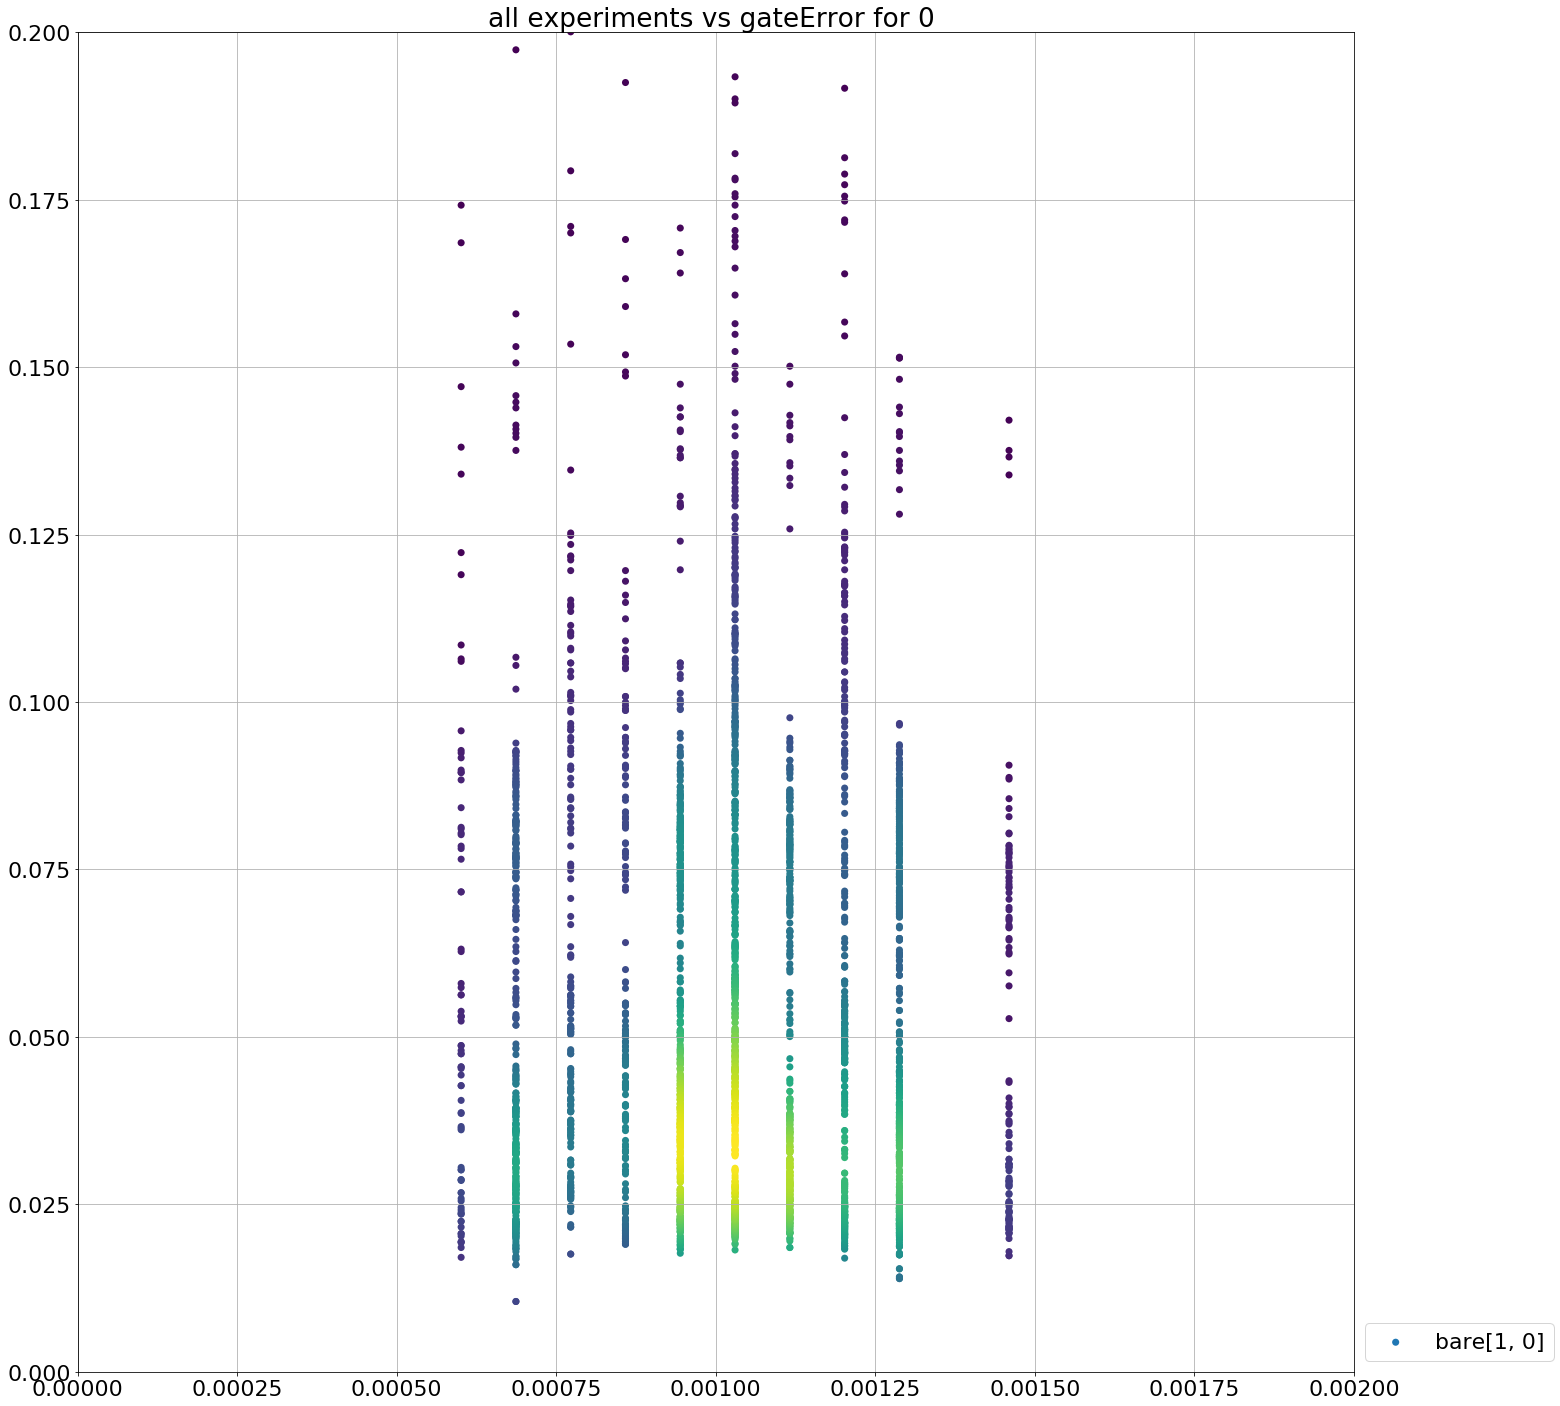

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [98]:
plottool.plot_everything_calib_data('data/Processed_data/', 0, 'gateError', 
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0,0.002],
                                    y_range=[0,0.2],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [0]])

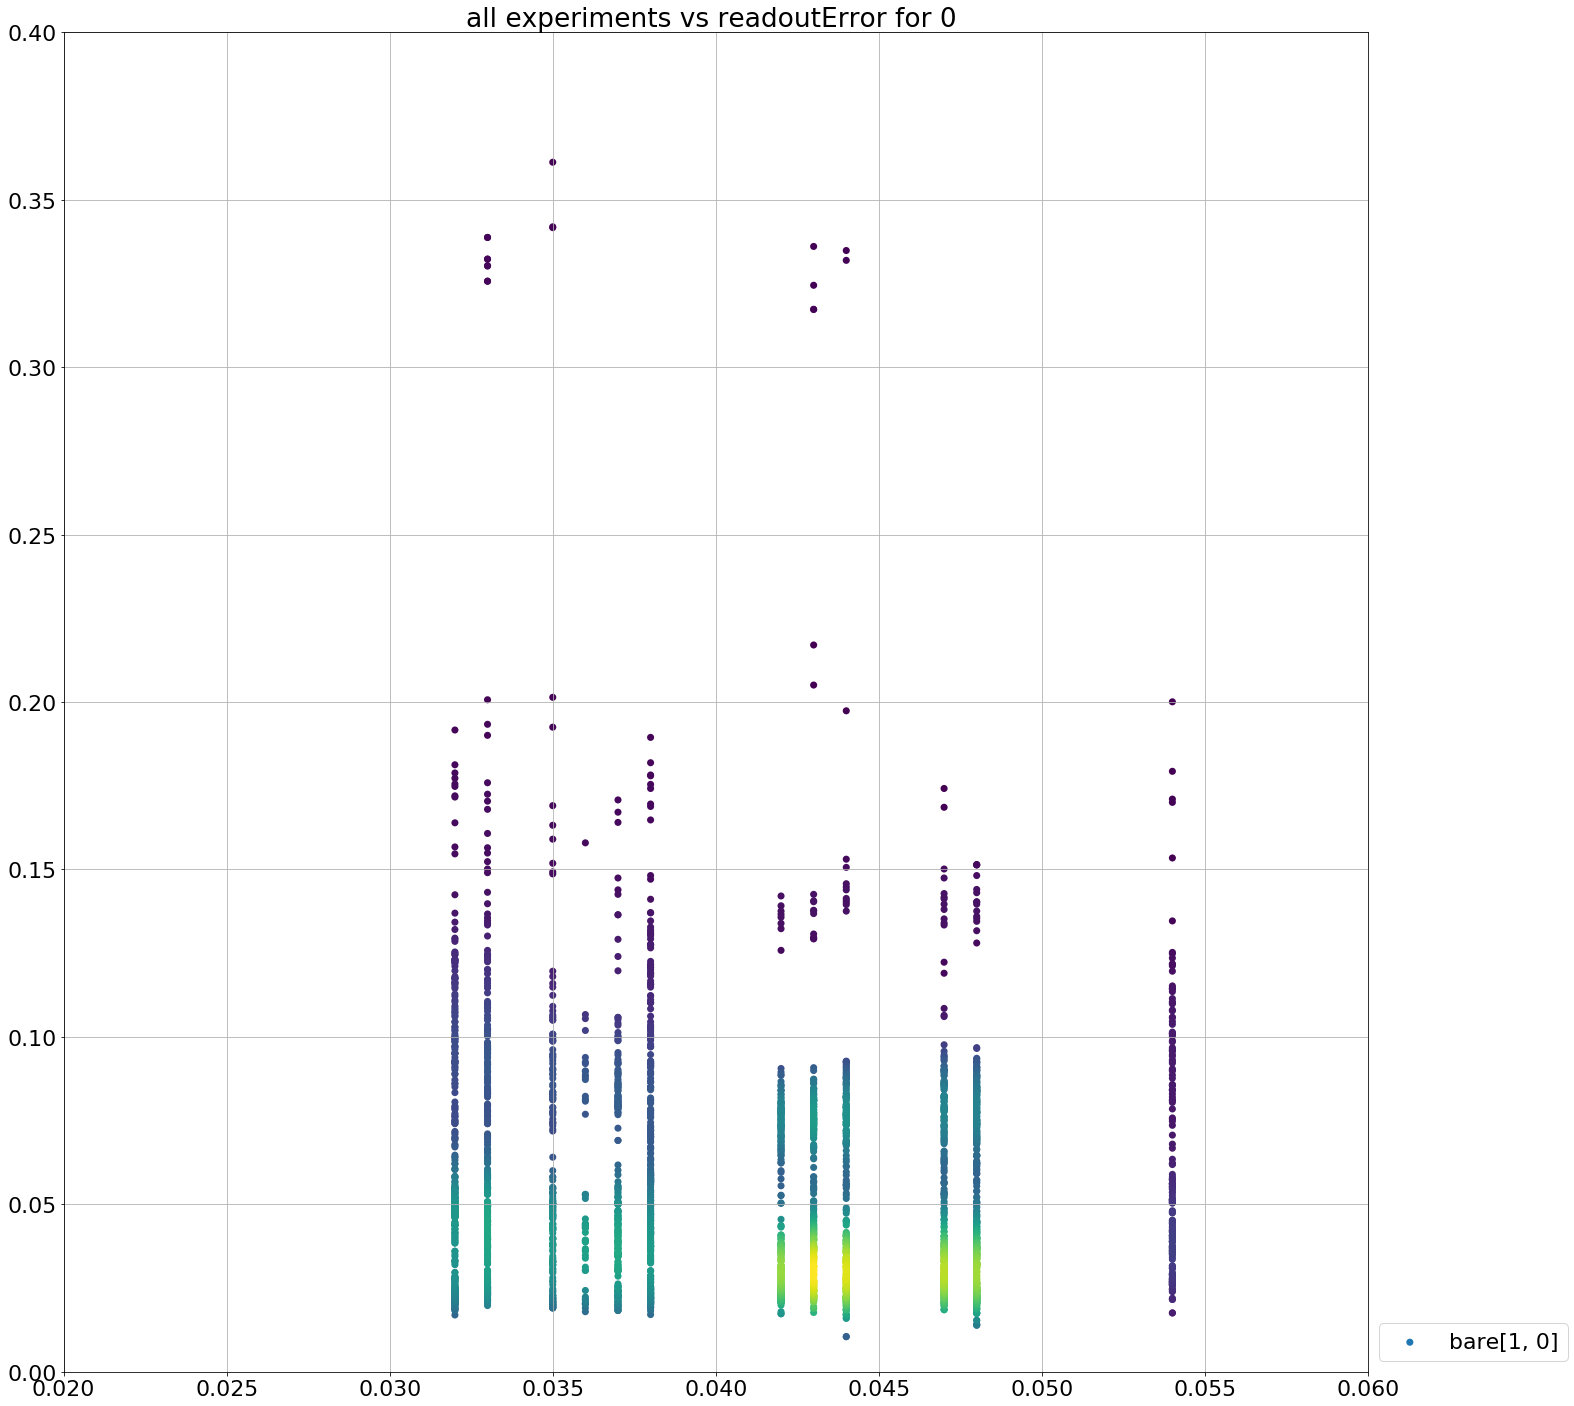

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [94]:
plottool.plot_everything_calib_data('data/Processed_data/', 0, 'readoutError',  
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.02,0.06], 
                                    y_range=[0,0.4],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [0]])

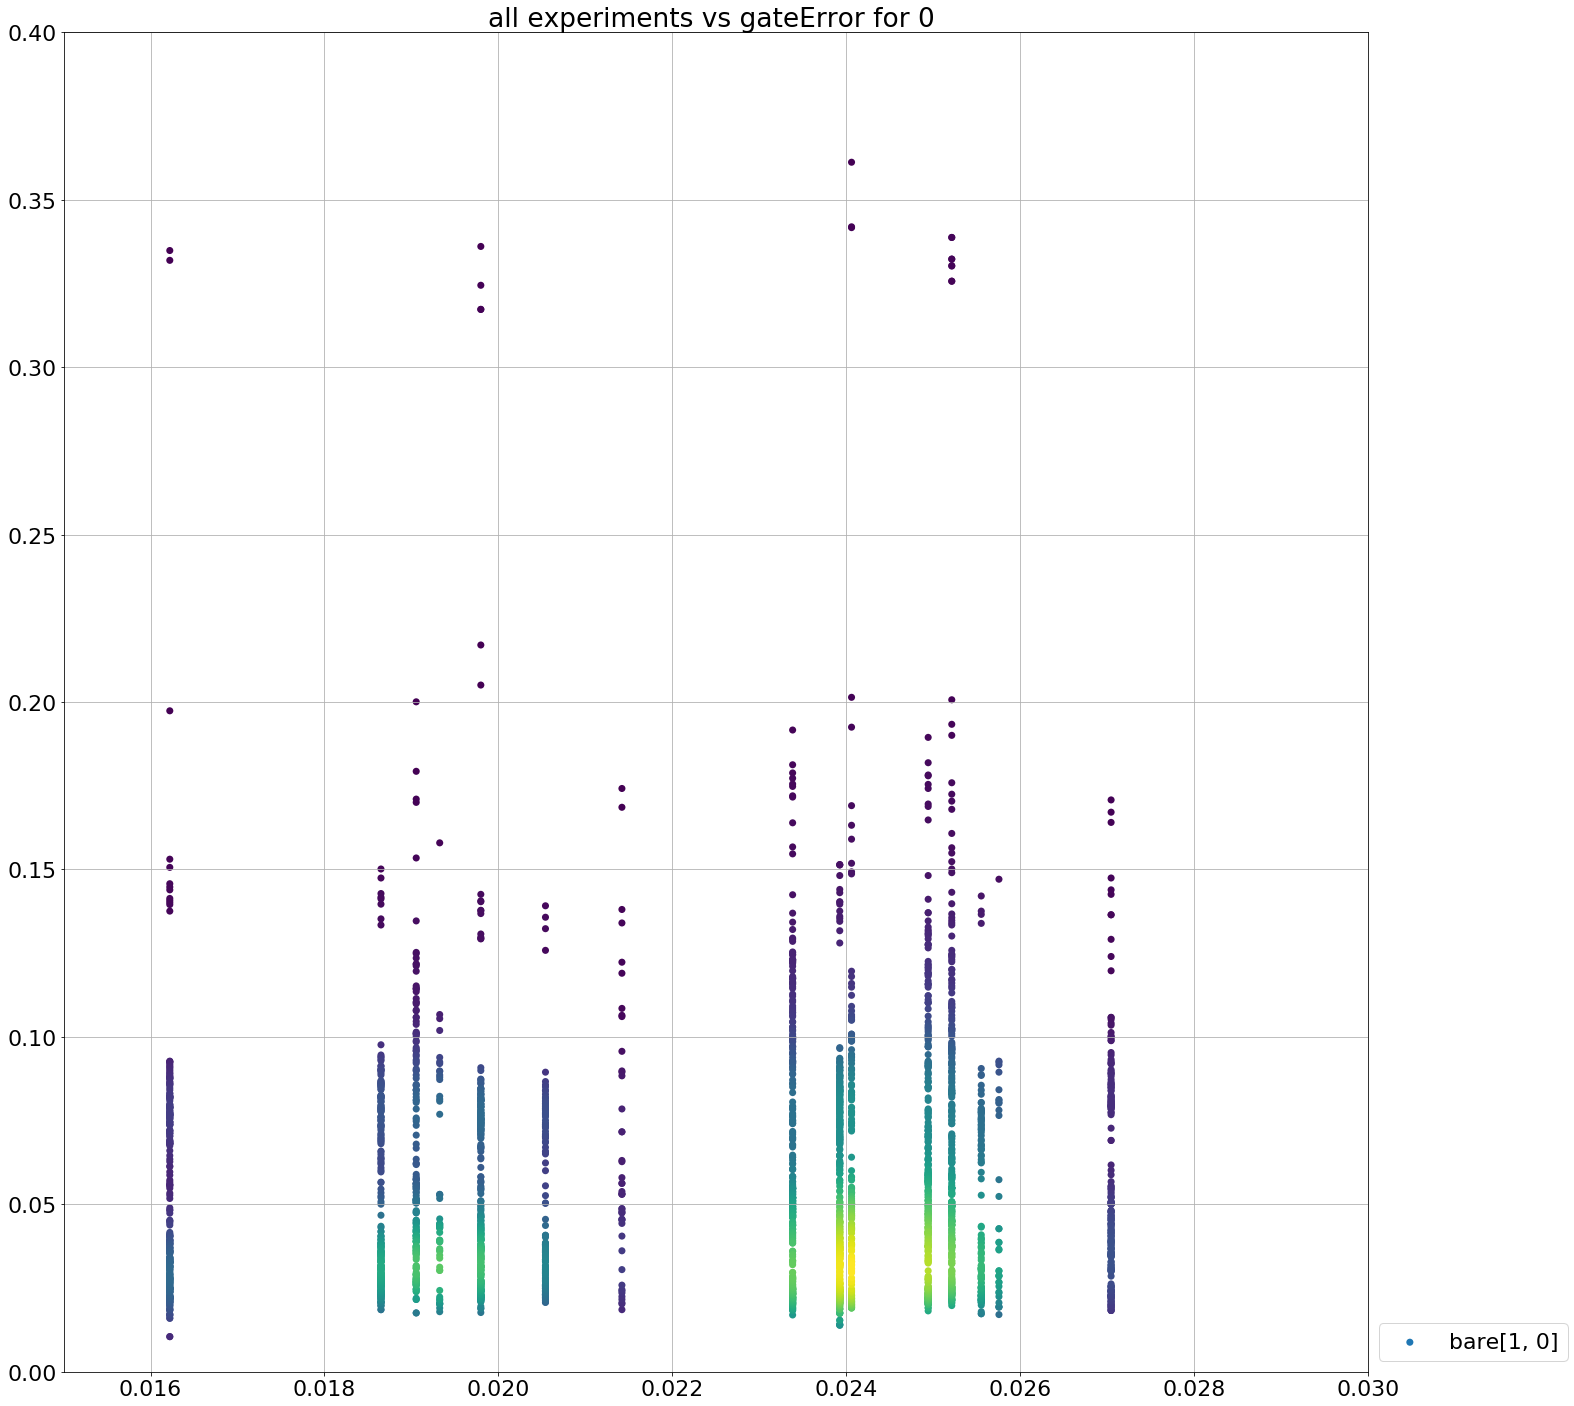

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [21]:
plottool.plot_everything_calib_data('data/Processed_data/', 0, 'gateError', 
                                    multi_qubit_param=True,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.015,0.03], 
                                    y_range=[0,0.4],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [0]])

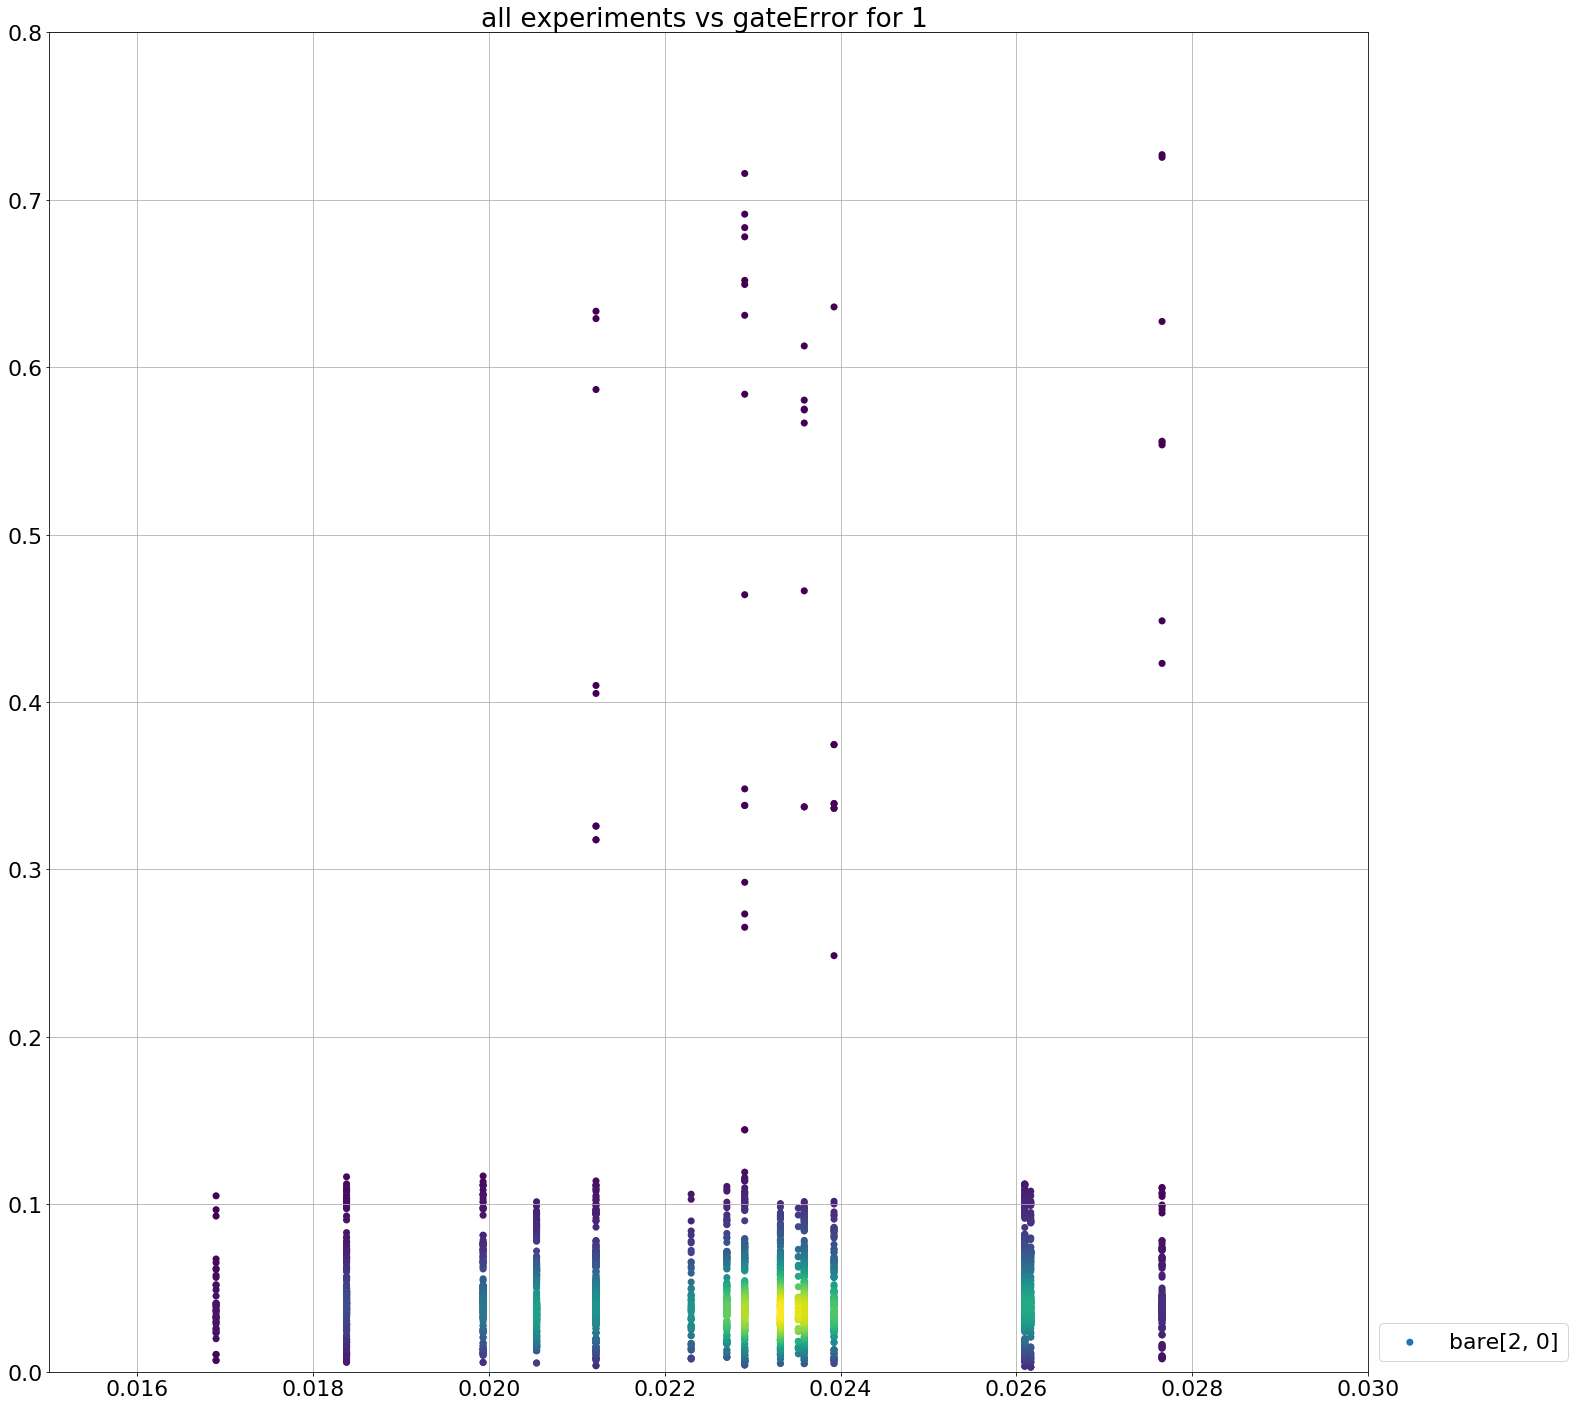

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [19]:
plottool.plot_everything_calib_data('data/Processed_data/', 1, 'gateError', 
                                    multi_qubit_param=True,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.015,0.03], 
                                    y_range=[0,0.8],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [1]])

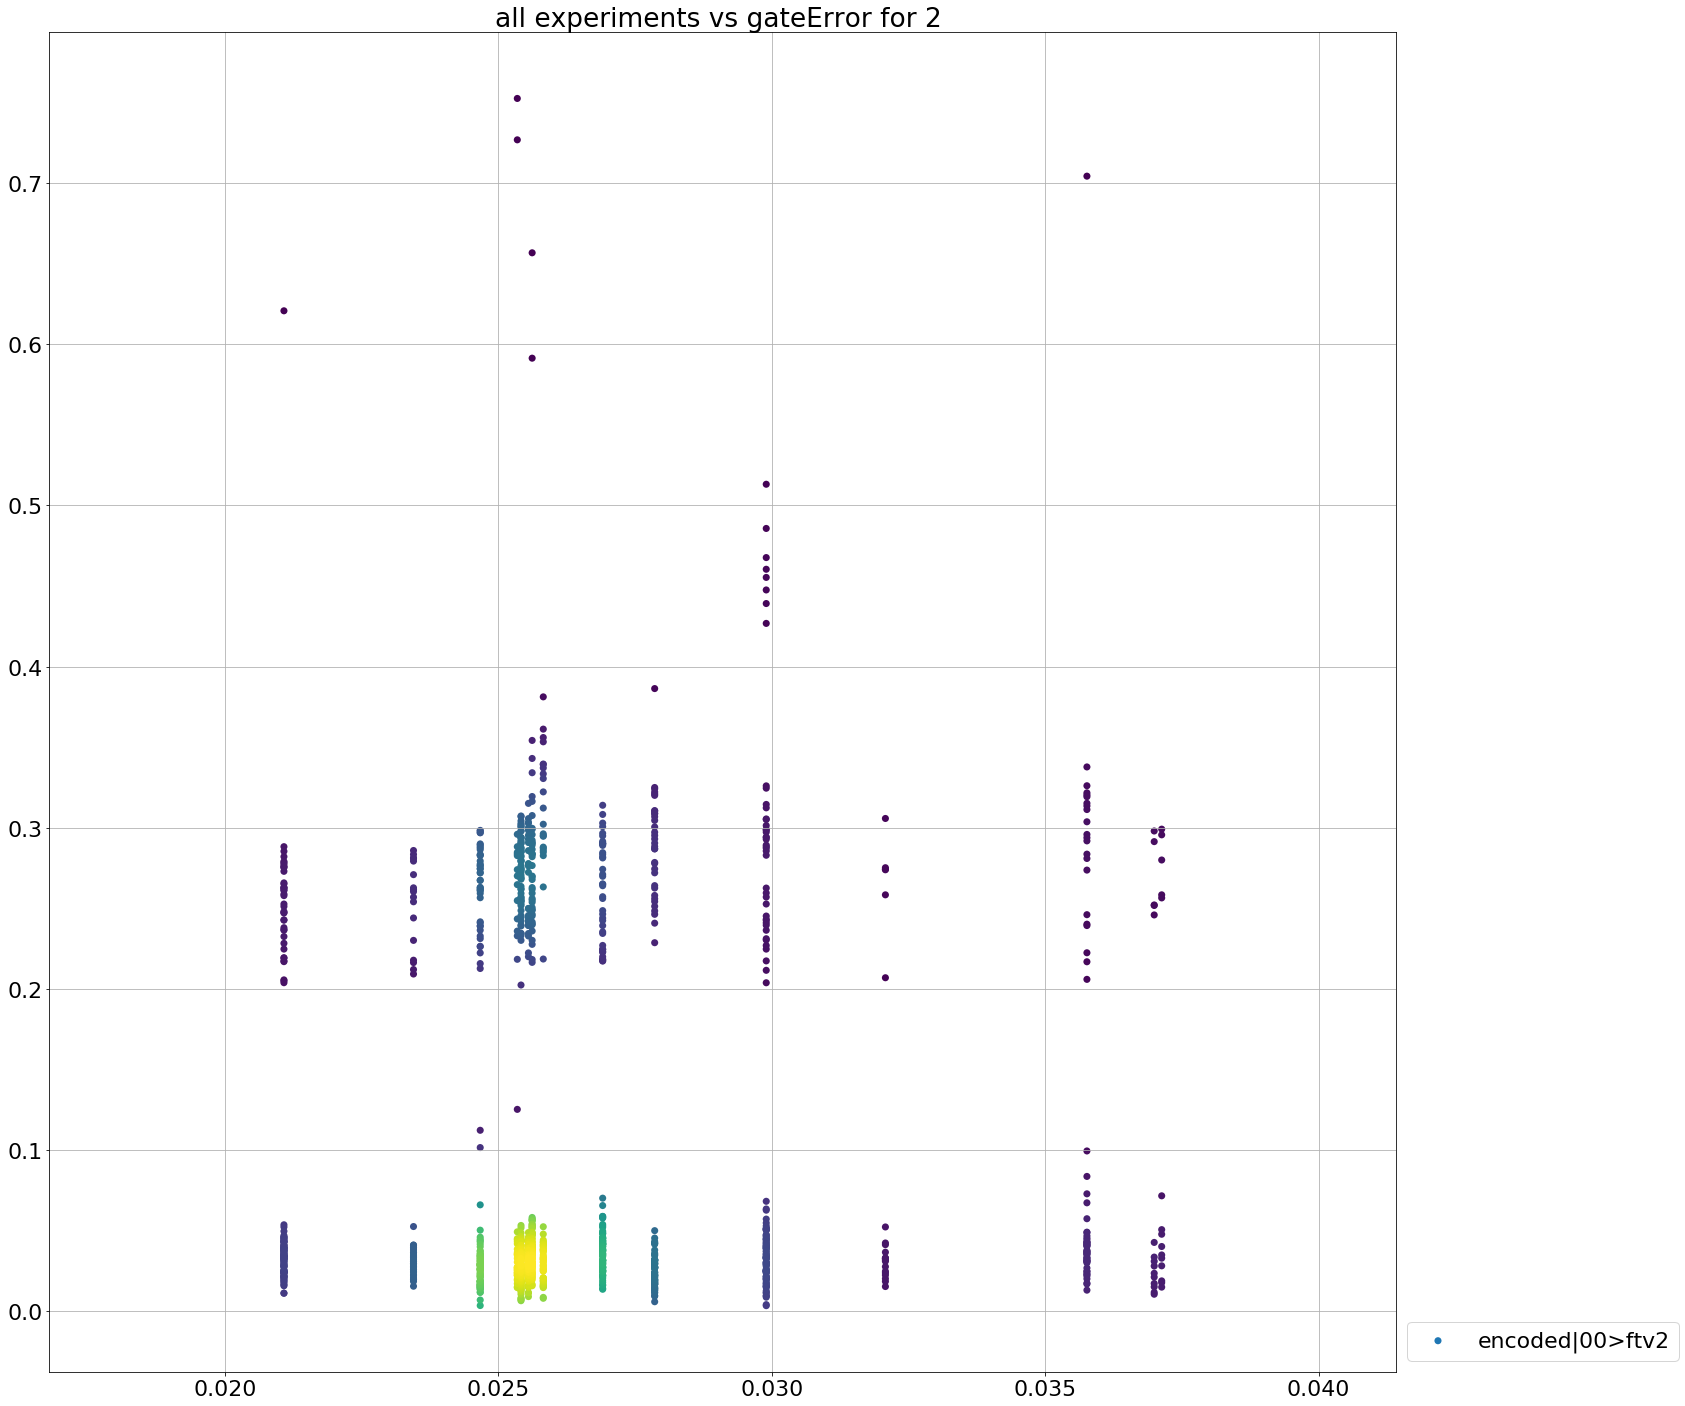

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [109]:
plottool.plot_everything_calib_data('data/Processed_data/', 2, 'gateError', 
                                    multi_qubit_param=True,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.01,0.035], 
                                    y_range=[0,0.15],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [7]])

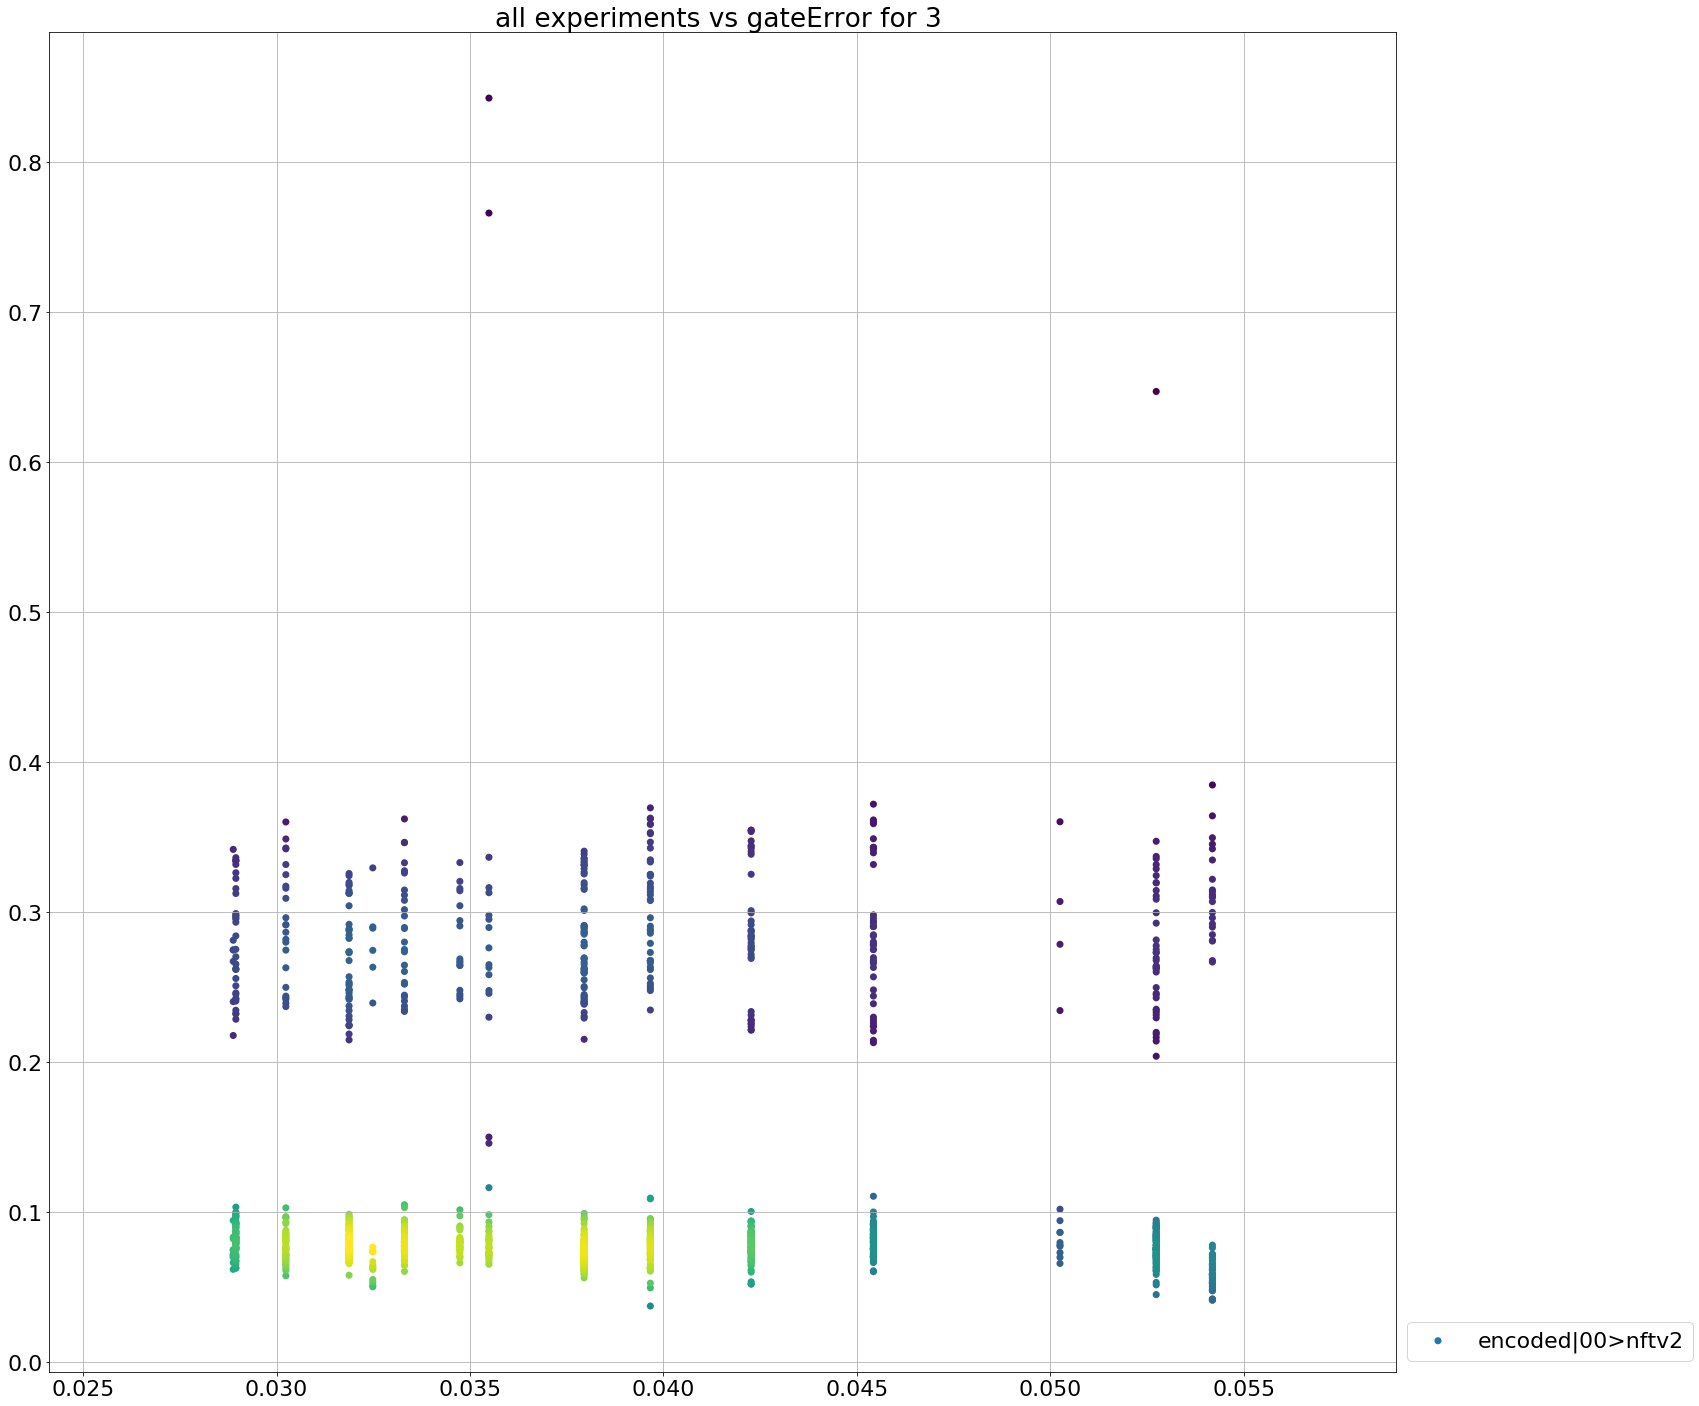

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [108]:
plottool.plot_everything_calib_data('data/Processed_data/', 3, 'gateError', 
                                    multi_qubit_param=True,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.01,0.055], 
                                    y_range=[0,0.15],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [9]])

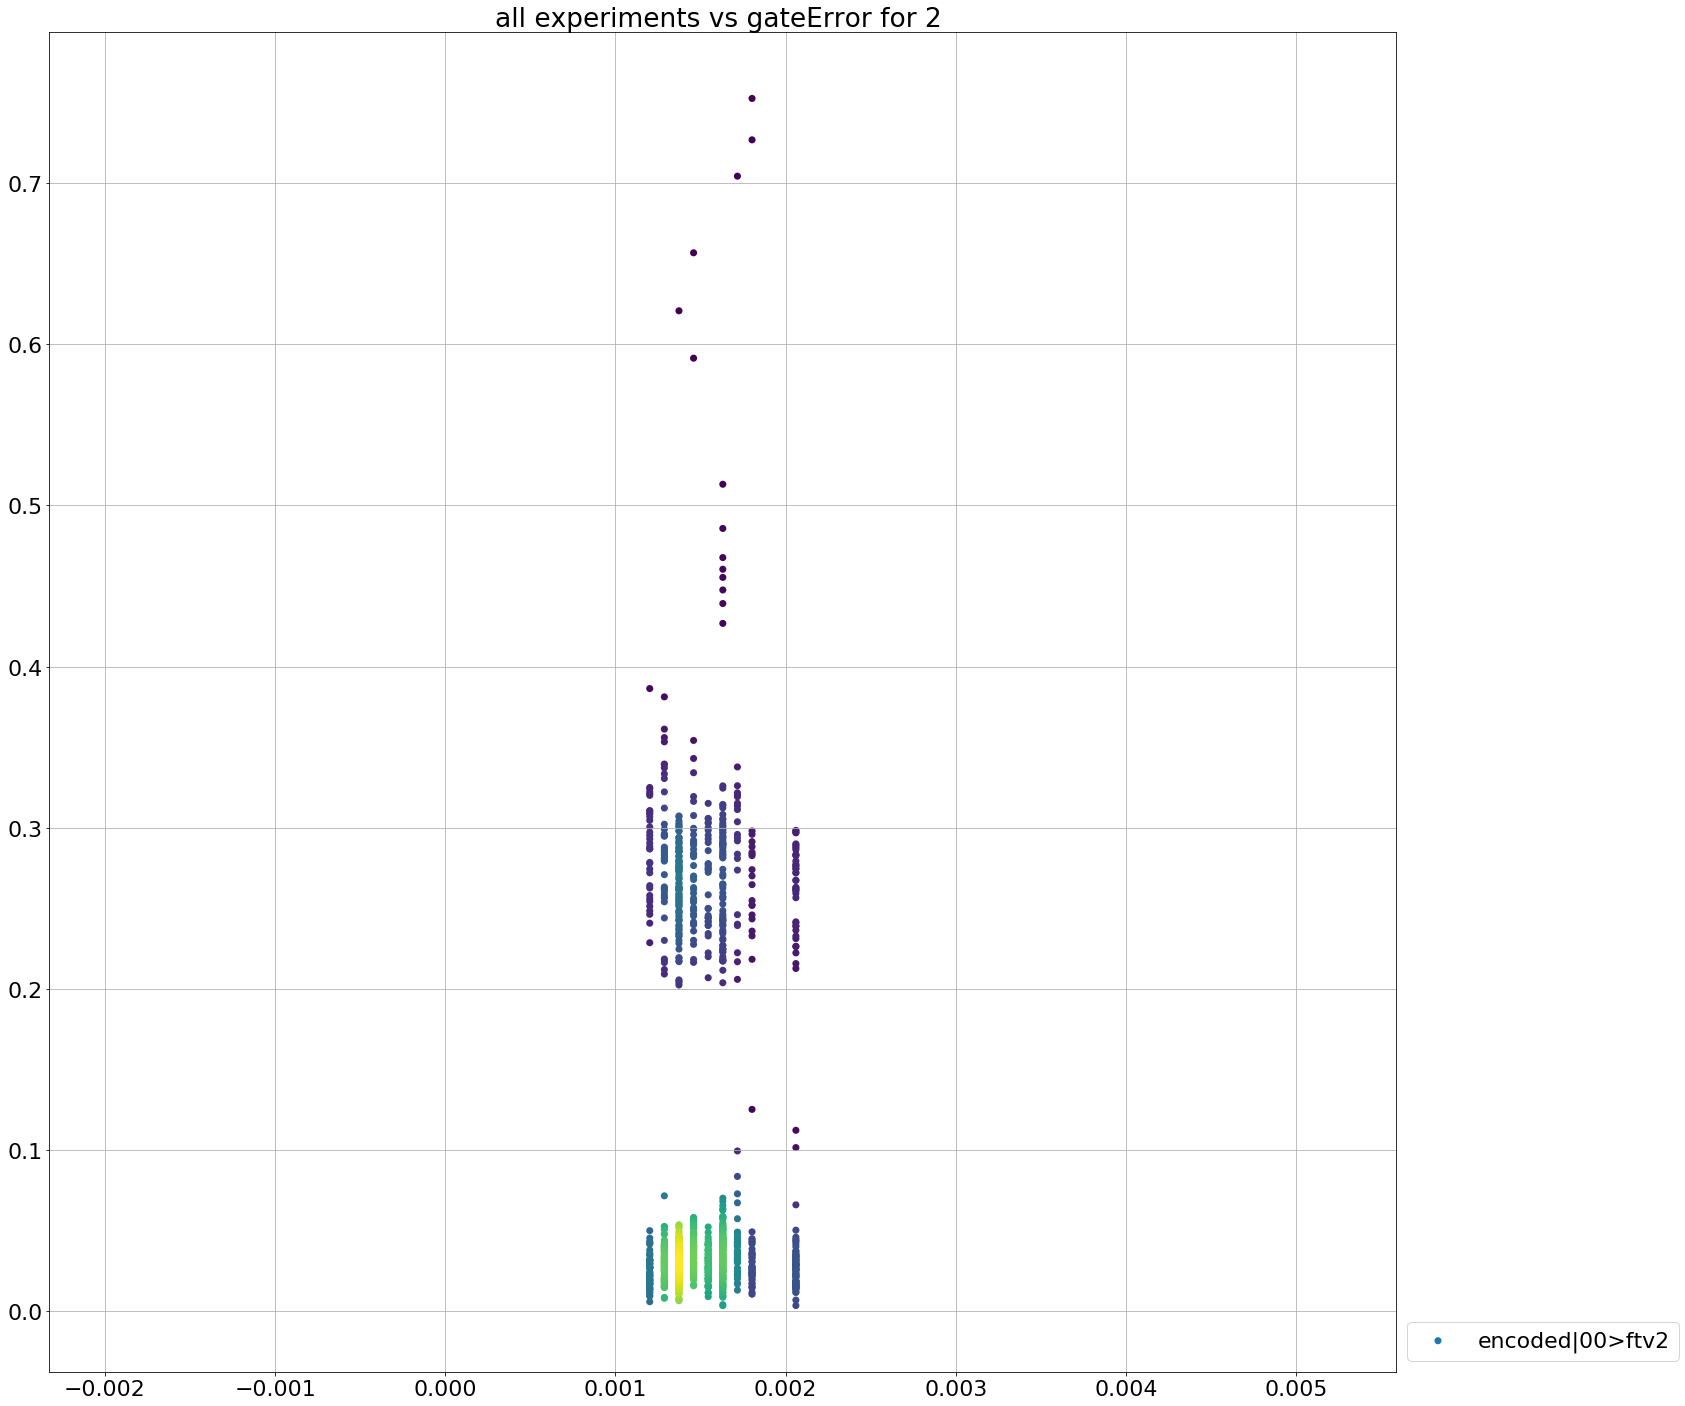

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [113]:
plottool.plot_everything_calib_data('data/Processed_data/', 2, 'gateError', 
                                    multi_qubit_param=False,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.01,0.035], 
                                    y_range=[0,0.4],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [7]])

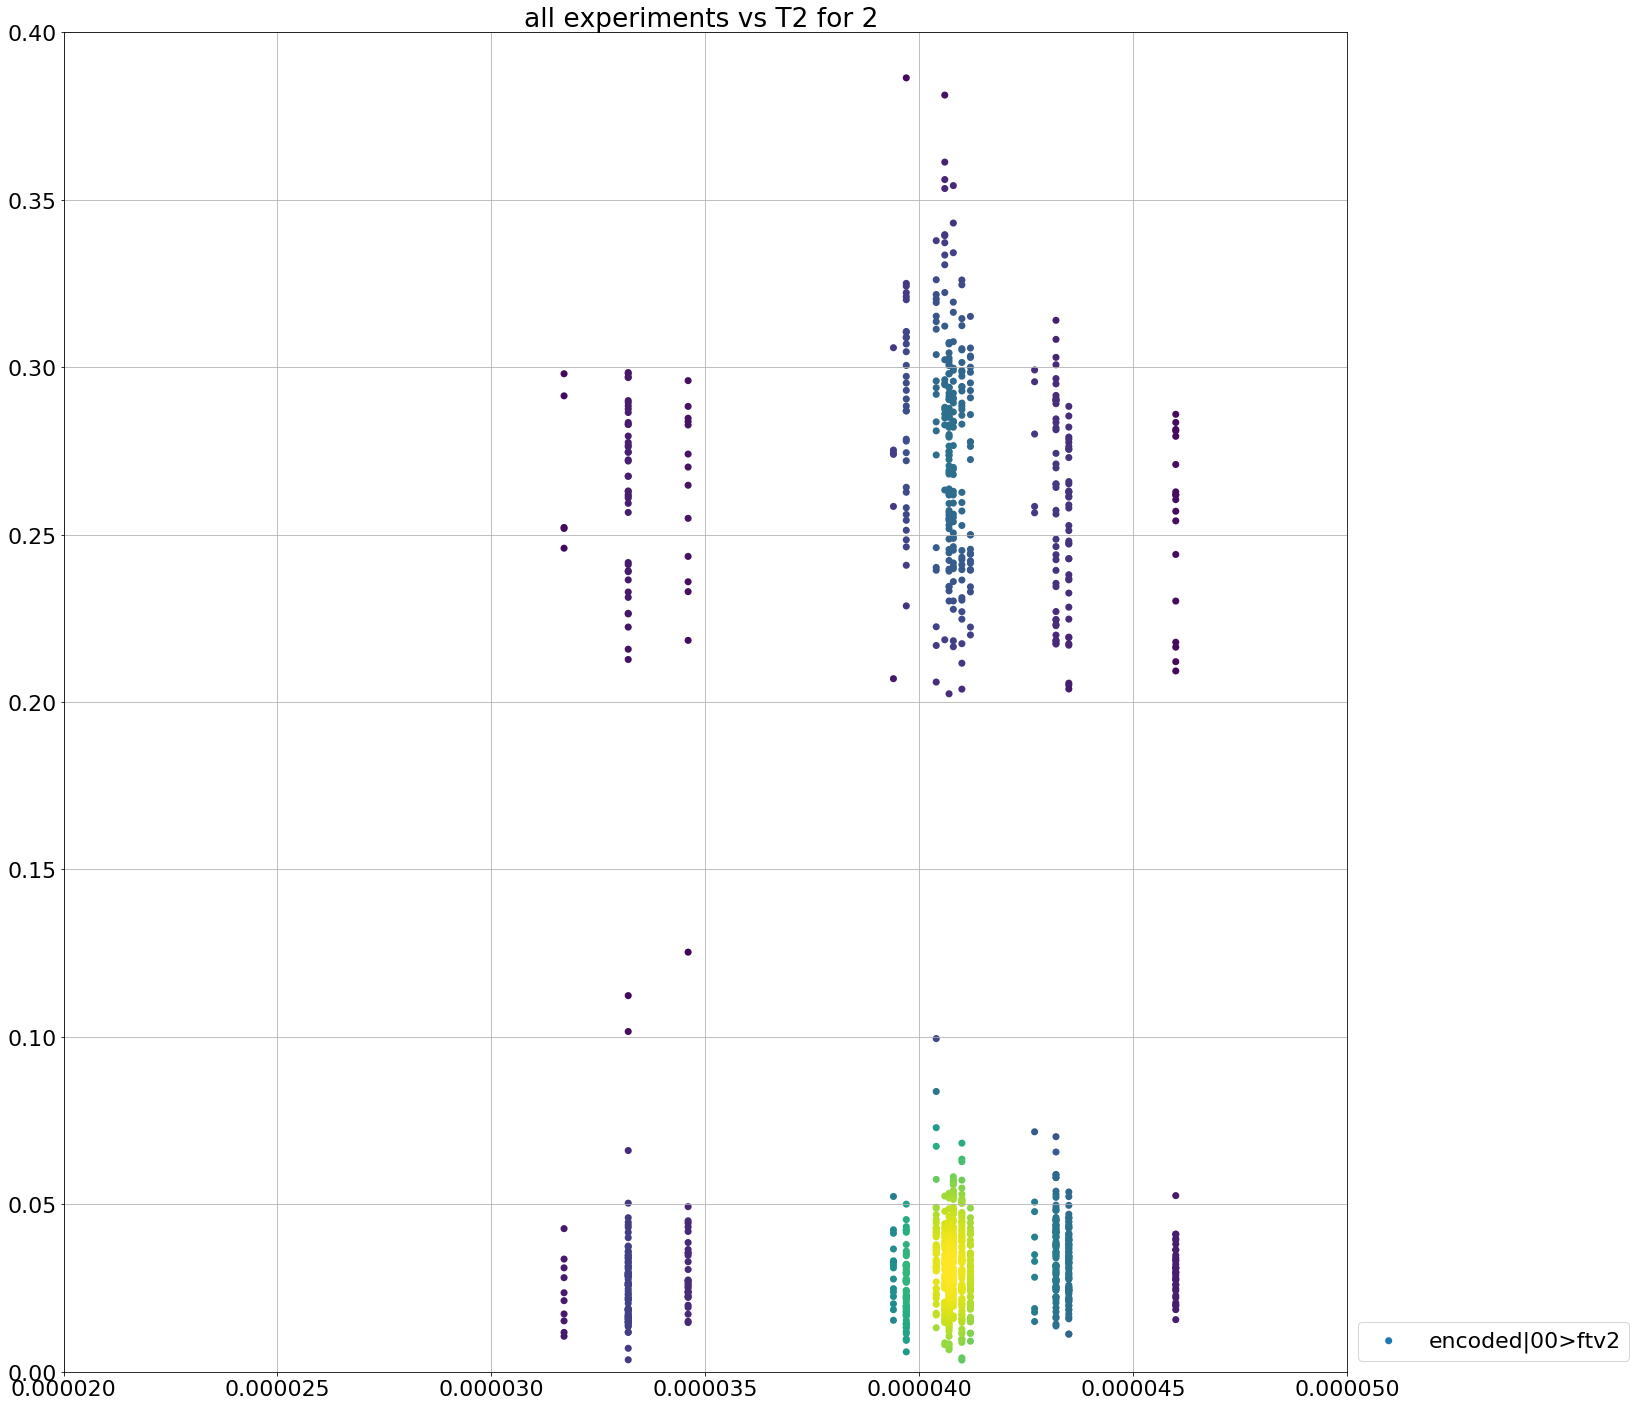

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [119]:
plottool.plot_everything_calib_data('data/Processed_data/', 2, 'T2', 
                                    multi_qubit_param=False,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.00002,0.00005], 
                                    y_range=[0,0.4],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [7]])

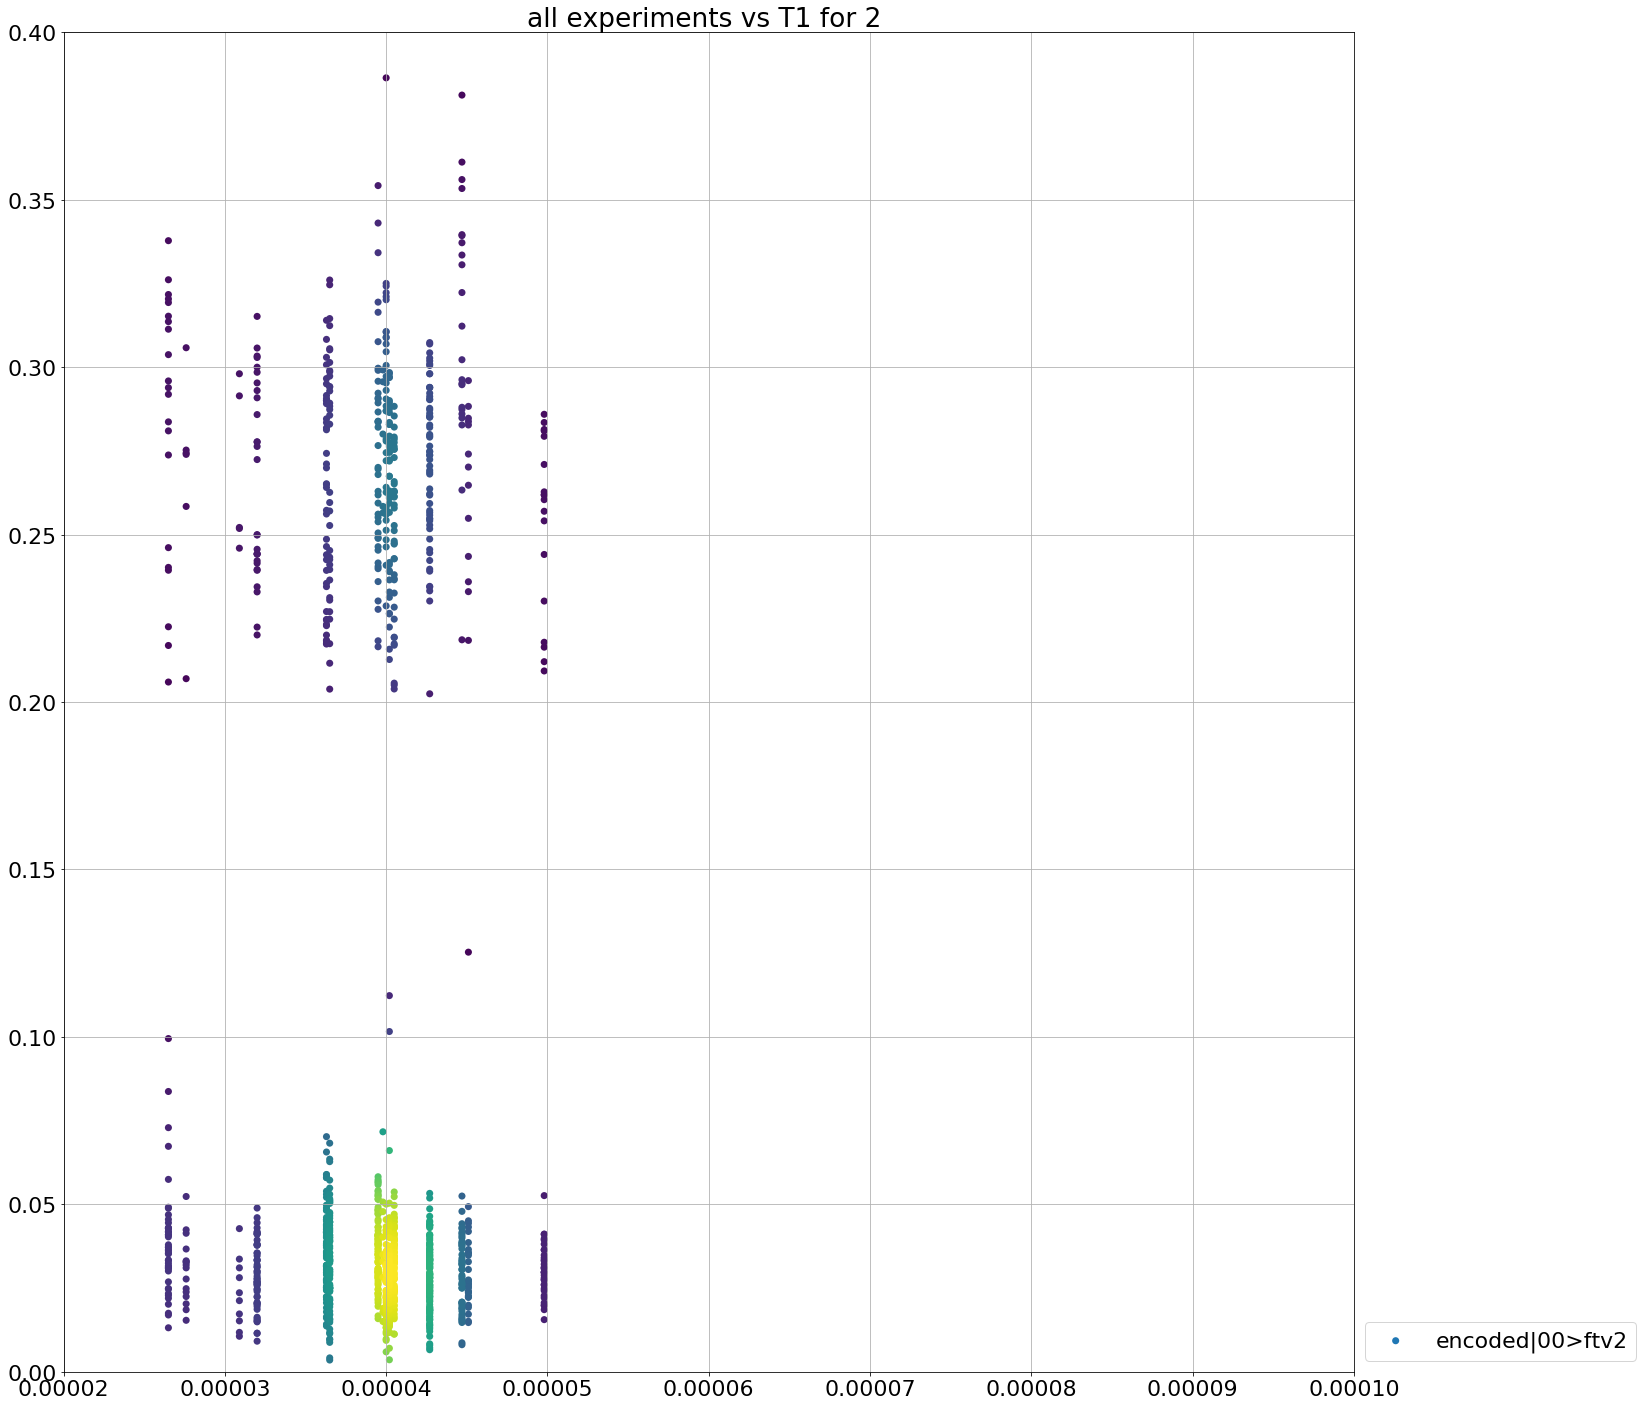

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [121]:
plottool.plot_everything_calib_data('data/Processed_data/', 2, 'T1', 
                                    multi_qubit_param=False,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.00002,0.0001], 
                                    y_range=[0,0.4],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [7]])

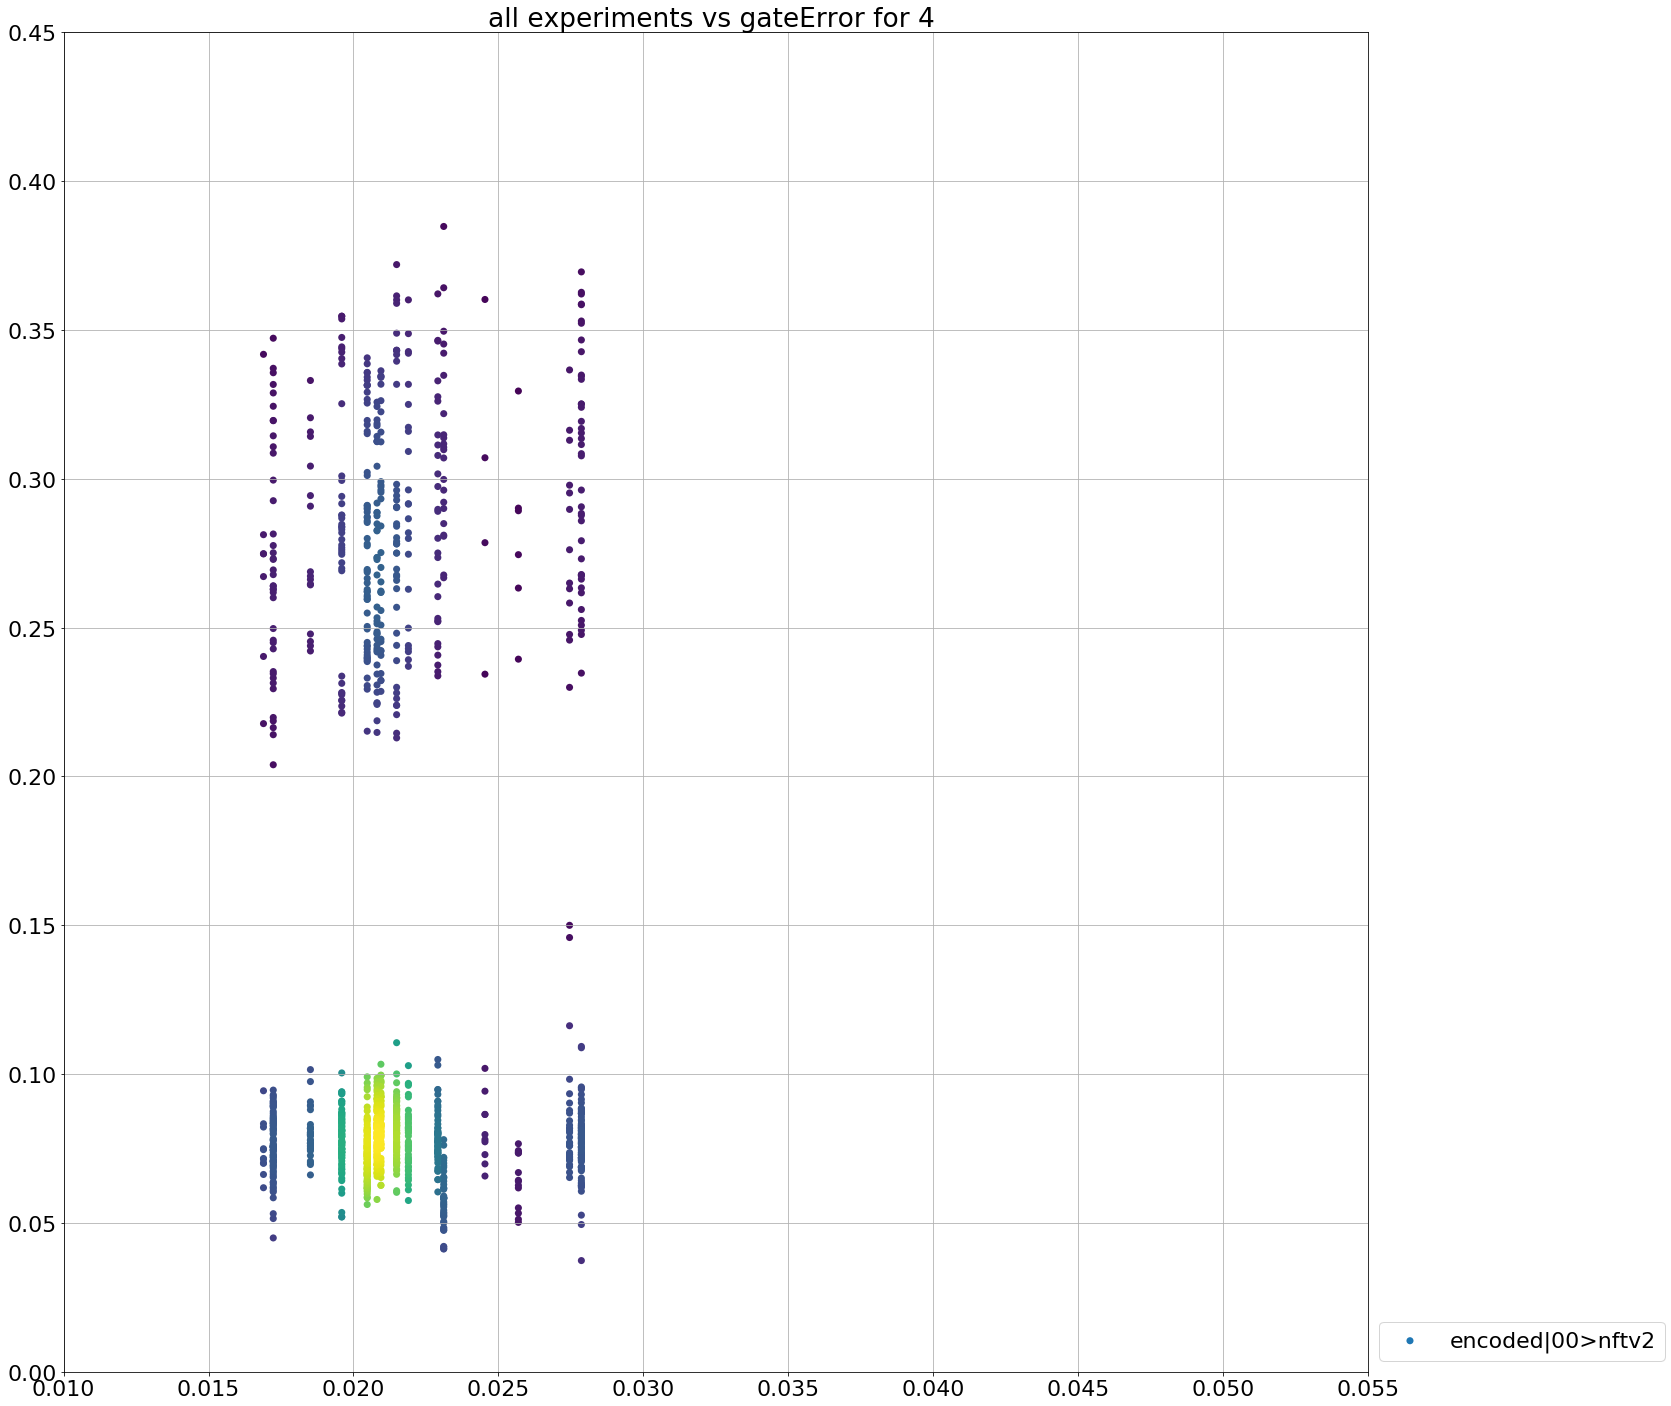

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [26]:
plottool.plot_everything_calib_data('data/Processed_data/', 4, 'gateError', 
                                    multi_qubit_param=True,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.01,0.055], 
                                    y_range=[0,0.45],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [9]])

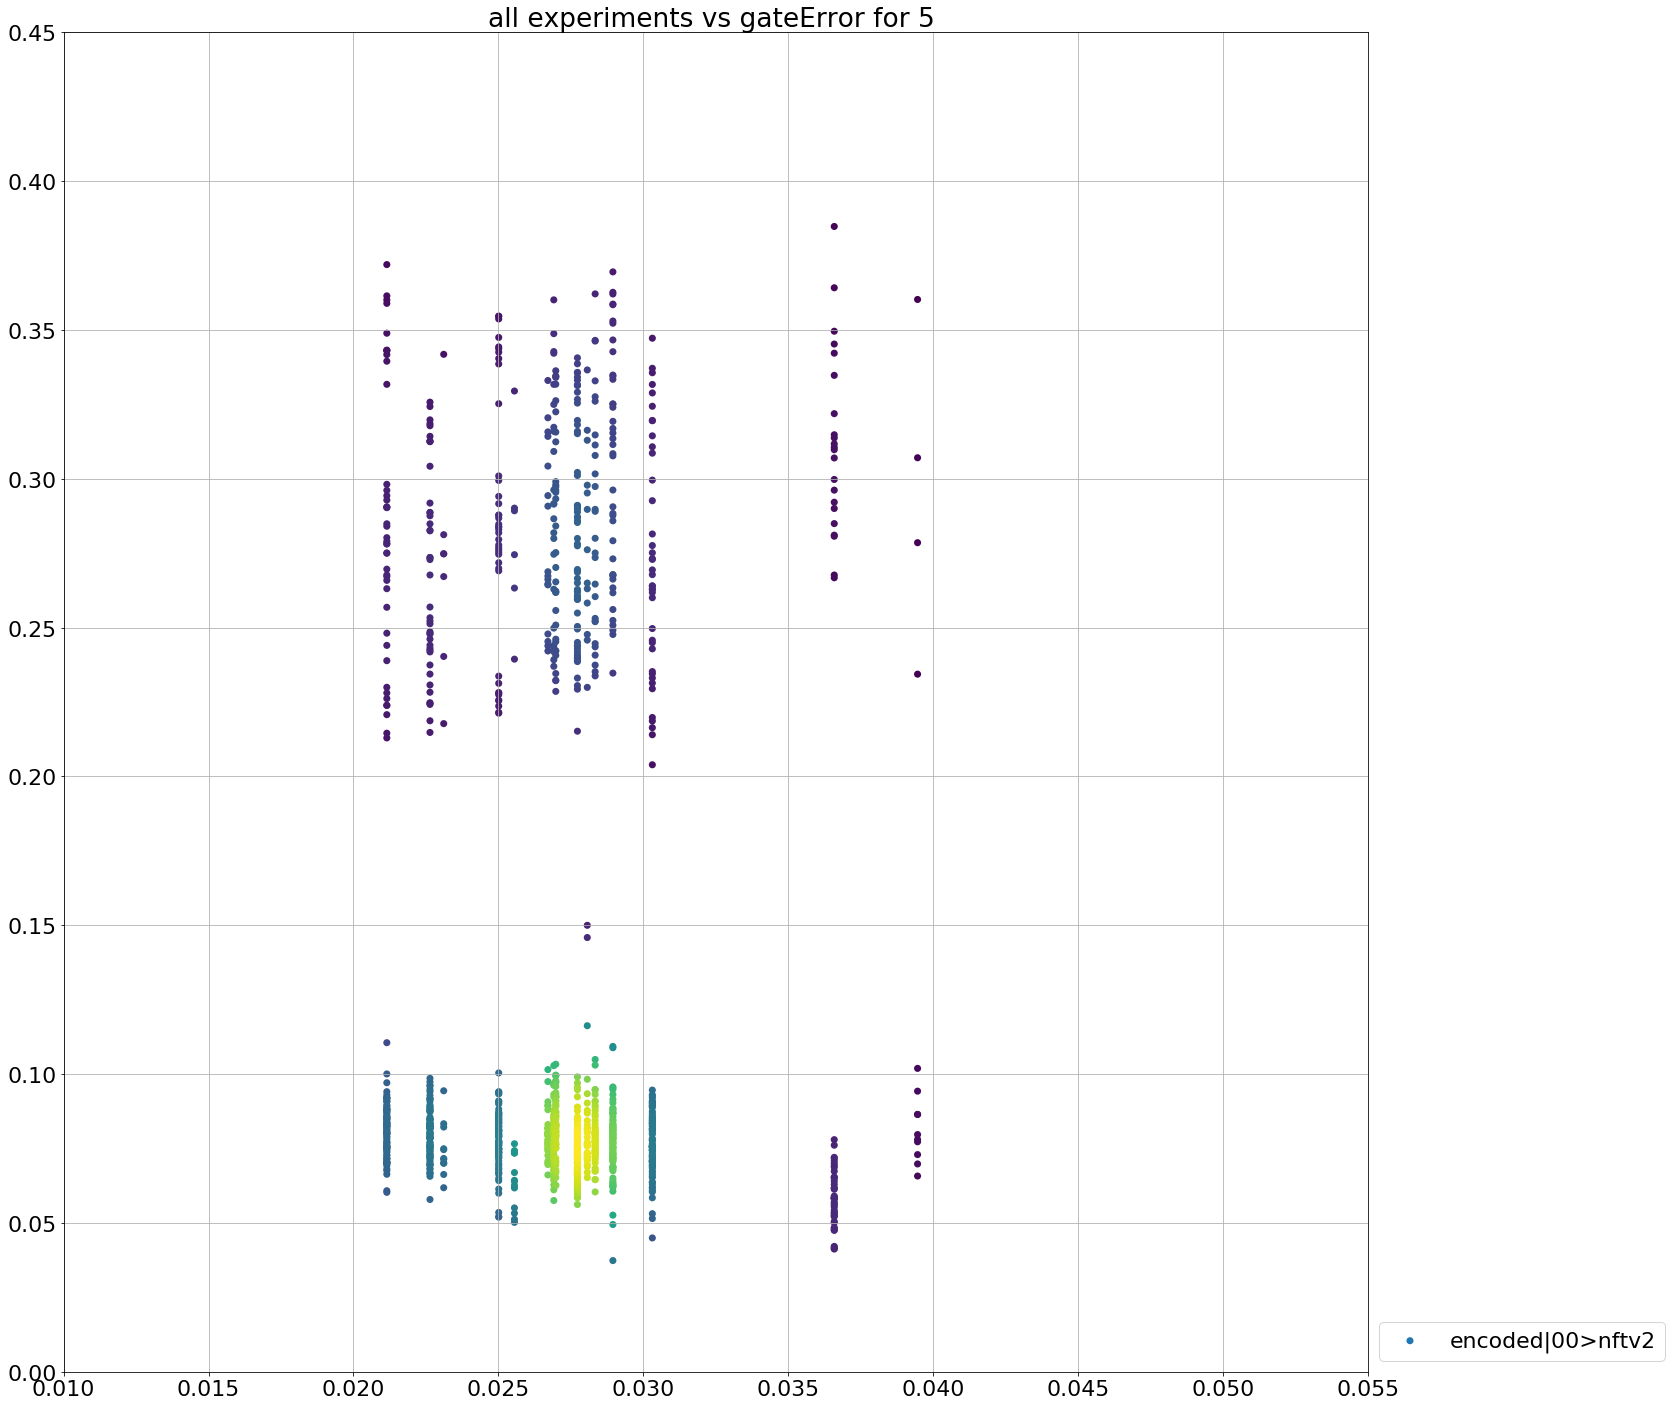

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [27]:
plottool.plot_everything_calib_data('data/Processed_data/', 5, 'gateError', 
                                    multi_qubit_param=True,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.01,0.055], 
                                    y_range=[0,0.45],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [9]])

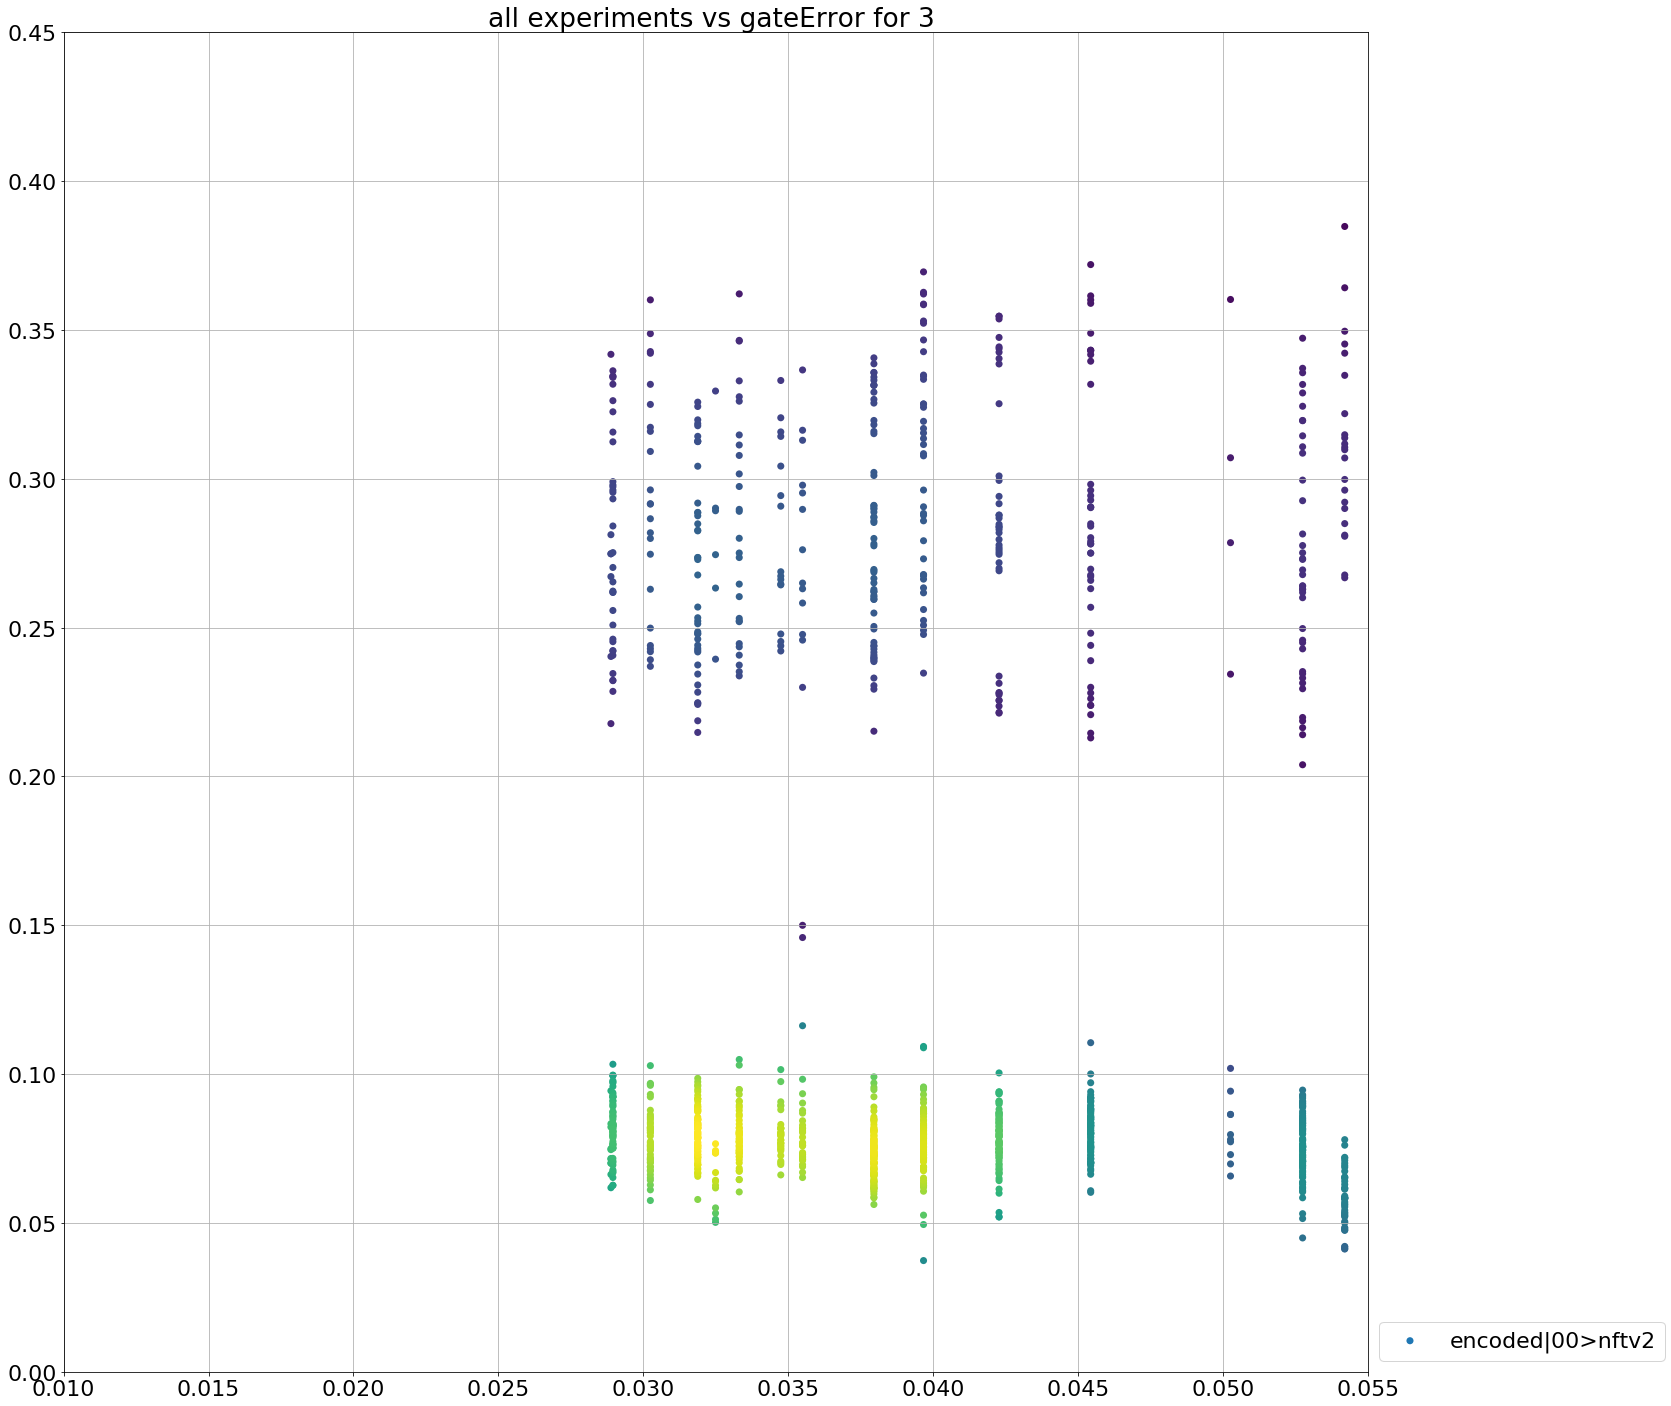

0 27398
bare[1, 0] 0.057210042596407676
bare[2, 0] 0.05058311544438844
bare[2, 1] 0.059090730673638826
bare[2, 4] 0.0608403631981383
bare[3, 2] 0.061699105618474685
bare[3, 4] 0.06880372206007973
encoded|00>ftv1 0.05582074628195924
encoded|00>ftv2 0.11393709344380022
encoded|00>nftv1 0.08152131850113092
encoded|00>nftv2 0.1467328867482615
encoded|0+> 0.03543286592703635
encoded|00>+|11> 0.02239111356440737


In [30]:
plottool.plot_everything_calib_data('data/Processed_data/', 3, 'gateError', 
                                    multi_qubit_param=True,
                                    logscalex=False, 
                                    logscaley=False, 
                                    x_range=[0.01,0.055], 
                                    y_range=[0,0.45],
                                    sublabels=[plottool.PLOT_LABELS[i] for i in [9]])

In [113]:
z = zip(*sorted(zip([7,6,7],[4,5,3],[7,8,9])))

In [114]:
for e in z:
    print(e)

(6, 7, 7)
(5, 3, 4)
(8, 9, 7)


In [124]:
max(*[6,7,8])

8

In [174]:
for j,cn in enumerate(exptool.CIRCUIT_NAMES):
    print('{} {}'.format(j+1,cn[1:]))

1 |00>
2 |0+>
3 X2|00>
4 X1|00>
5 |00>+|11>
6 Z2|0+>
7 HHS|00>
8 X1|0+>
9 X2-X1|00>
10 Z2|00>+|11>
11 X1|00>+|11>
12 Z2-HHS|00>
13 Z1-HHS|00>
14 Z2-X1|0+>
15 X2-Z2|00>+|11>
16 Z2-Z1-HHS|00>
17 CZ-HHS|00>
18 CZ-Z2-HHS|00>
19 CZ-Z1-HHS|00>
20 X2-CZ-HHS-X1|00>


In [53]:
importlib.reload(exptool)
importlib.reload(plottool)

<module 'tools.Ploting_tools' from '/Users/cvuillot/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Ploting_tools.py'>

In [54]:
plottool.save_everything_calib_data_avg('data/Processed_data/', 'data/Table_data/')

0 27398


## Old parameters (on sparrow)

In [66]:
import statistics
from statsmodels.stats.weightstats import DescrStatsW
num_runs = [9, 12, 5, 10]
total_runs = sum(num_runs)
1/total_runs*sum([w*e for w,e in zip(num_runs,[1,2,3,4])])

weighted_stats = DescrStatsW([103.8,93.8,85.8,77.6], weights=num_runs, ddof=0)
print(weighted_stats.std)
print(weighted_stats.mean)
print(statistics.stdev(weighted_stats.asrepeats()))
print(statistics.mean(weighted_stats.asrepeats()))

9.85443435937
90.6888888889
9.994220552121334
90.6888888889


T1

In [45]:
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[33.9,56.4,47.9,52.8])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[54.5,32.8,41.1,58.3])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[58.2,54.5,56.1,54.1])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[54.9,47.2,46.4,41.6])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[46,58.2,64.4,55.7])]))

48.59444444444444
46.46111111111111
55.53611111111111
47.45833333333333
55.31666666666666


In [68]:
weighted_stats = DescrStatsW([33.9,56.4,47.9,52.8], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([54.5,32.8,41.1,58.3], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([58.2,54.5,56.1,54.1], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([54.9,47.2,46.4,41.6], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([46,58.2,64.4,55.7], weights=num_runs, ddof=0)
print(weighted_stats.std)

8.90339961427
11.0131557133
1.65800294494
4.85342805539
5.99761526683


T2

In [69]:
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[35.1,36.4,41.4,45.9])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[50.7,21.6,35.3,51.1])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[103.8,93.8,85.8,77.6])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[82.4,58.8,50.2,54.1])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[59.9,86.9,100.1,82.2])]))

39.40833333333333
38.97222222222222
90.68888888888888
62.19999999999999
80.67777777777778


In [70]:
weighted_stats = DescrStatsW([35.1,36.4,41.4,45.9], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([50.7,21.6,35.3,51.1], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([103.8,93.8,85.8,77.6], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([82.4,58.8,50.2,54.1], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([59.9,86.9,100.1,82.2], weights=num_runs, ddof=0)
print(weighted_stats.std)

4.4625213974
13.3308875072
9.85443435937
12.0036799913
13.1859797409


gateError

In [71]:
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[.24,.23,.21,.23])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[.23,.42,.35,.19])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[.57,.37,.37,.38])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[.87,.33,.4,.476])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[.37,.33,.28,.33])]))

0.2297222222222222
0.29888888888888887
0.4227777777777777
0.5152777777777777
0.33305555555555555


In [72]:
weighted_stats = DescrStatsW([.24,.23,.21,.23], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([.23,.42,.35,.19], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([.57,.37,.37,.38], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([.87,.33,.4,.476], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([.37,.33,.28,.33], weights=num_runs, ddof=0)
print(weighted_stats.std)

0.00897097514553
0.0986514002203
0.0851016095654
0.212541317697
0.0271640534985


readoutError

In [73]:
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[1.7,2,1.5,2.1])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[10.9,6.3,5.3,9.7])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[1.8,1.6,1,1.2])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[16.8,12.5,4.8,11.7])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[7.4,7.1,5.2,5.8])]))

1.883333333333333
8.255555555555555
1.4555555555555557
12.283333333333333
6.55


In [74]:
weighted_stats = DescrStatsW([1.7,2,1.5,2.1], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([10.9,6.3,5.3,9.7], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([1.8,1.6,1,1.2], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([16.8,12.5,4.8,11.7], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([7.4,7.1,5.2,5.8], weights=num_runs, ddof=0)
print(weighted_stats.std)

0.215380799722
2.19449367033
0.289102485139
3.60389449839
0.831163842653


Two qubit gates

In [75]:
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[3.74,5.02,3.65,3.23])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[2.58,3.17,3.15,3.02])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[4.01,5.82,3.97,3.98])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[3.62,3.47,3.26,4.19])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[6.94,5.19,5.46,7.15])]))
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[8.9,3.66,4.42,6.11])]))

4.012499999999999
2.9780555555555552
4.599444444444444
3.6783333333333337
6.209444444444444
5.756111111111111


In [76]:
weighted_stats = DescrStatsW([3.74,5.02,3.65,3.23], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([2.58,3.17,3.15,3.02], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([4.01,5.82,3.97,3.98], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([3.62,3.47,3.26,4.19], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([6.94,5.19,5.46,7.15], weights=num_runs, ddof=0)
print(weighted_stats.std)
weighted_stats = DescrStatsW([8.9,3.66,4.42,6.11], weights=num_runs, ddof=0)
print(weighted_stats.std)

0.73841186565
0.237671802708
0.863169046288
0.335182371586
0.8964341224
2.0538504189


Fridge

In [77]:
print(1/total_runs*sum([w*e for w,e in zip(num_runs,[0.018439,0.019558,0.019102,0.017421])]))
weighted_stats = DescrStatsW([0.018439,0.019558,0.019102,0.017421], weights=num_runs, ddof=0)
print(weighted_stats.std)

0.018621305555555554
0.000856195487136


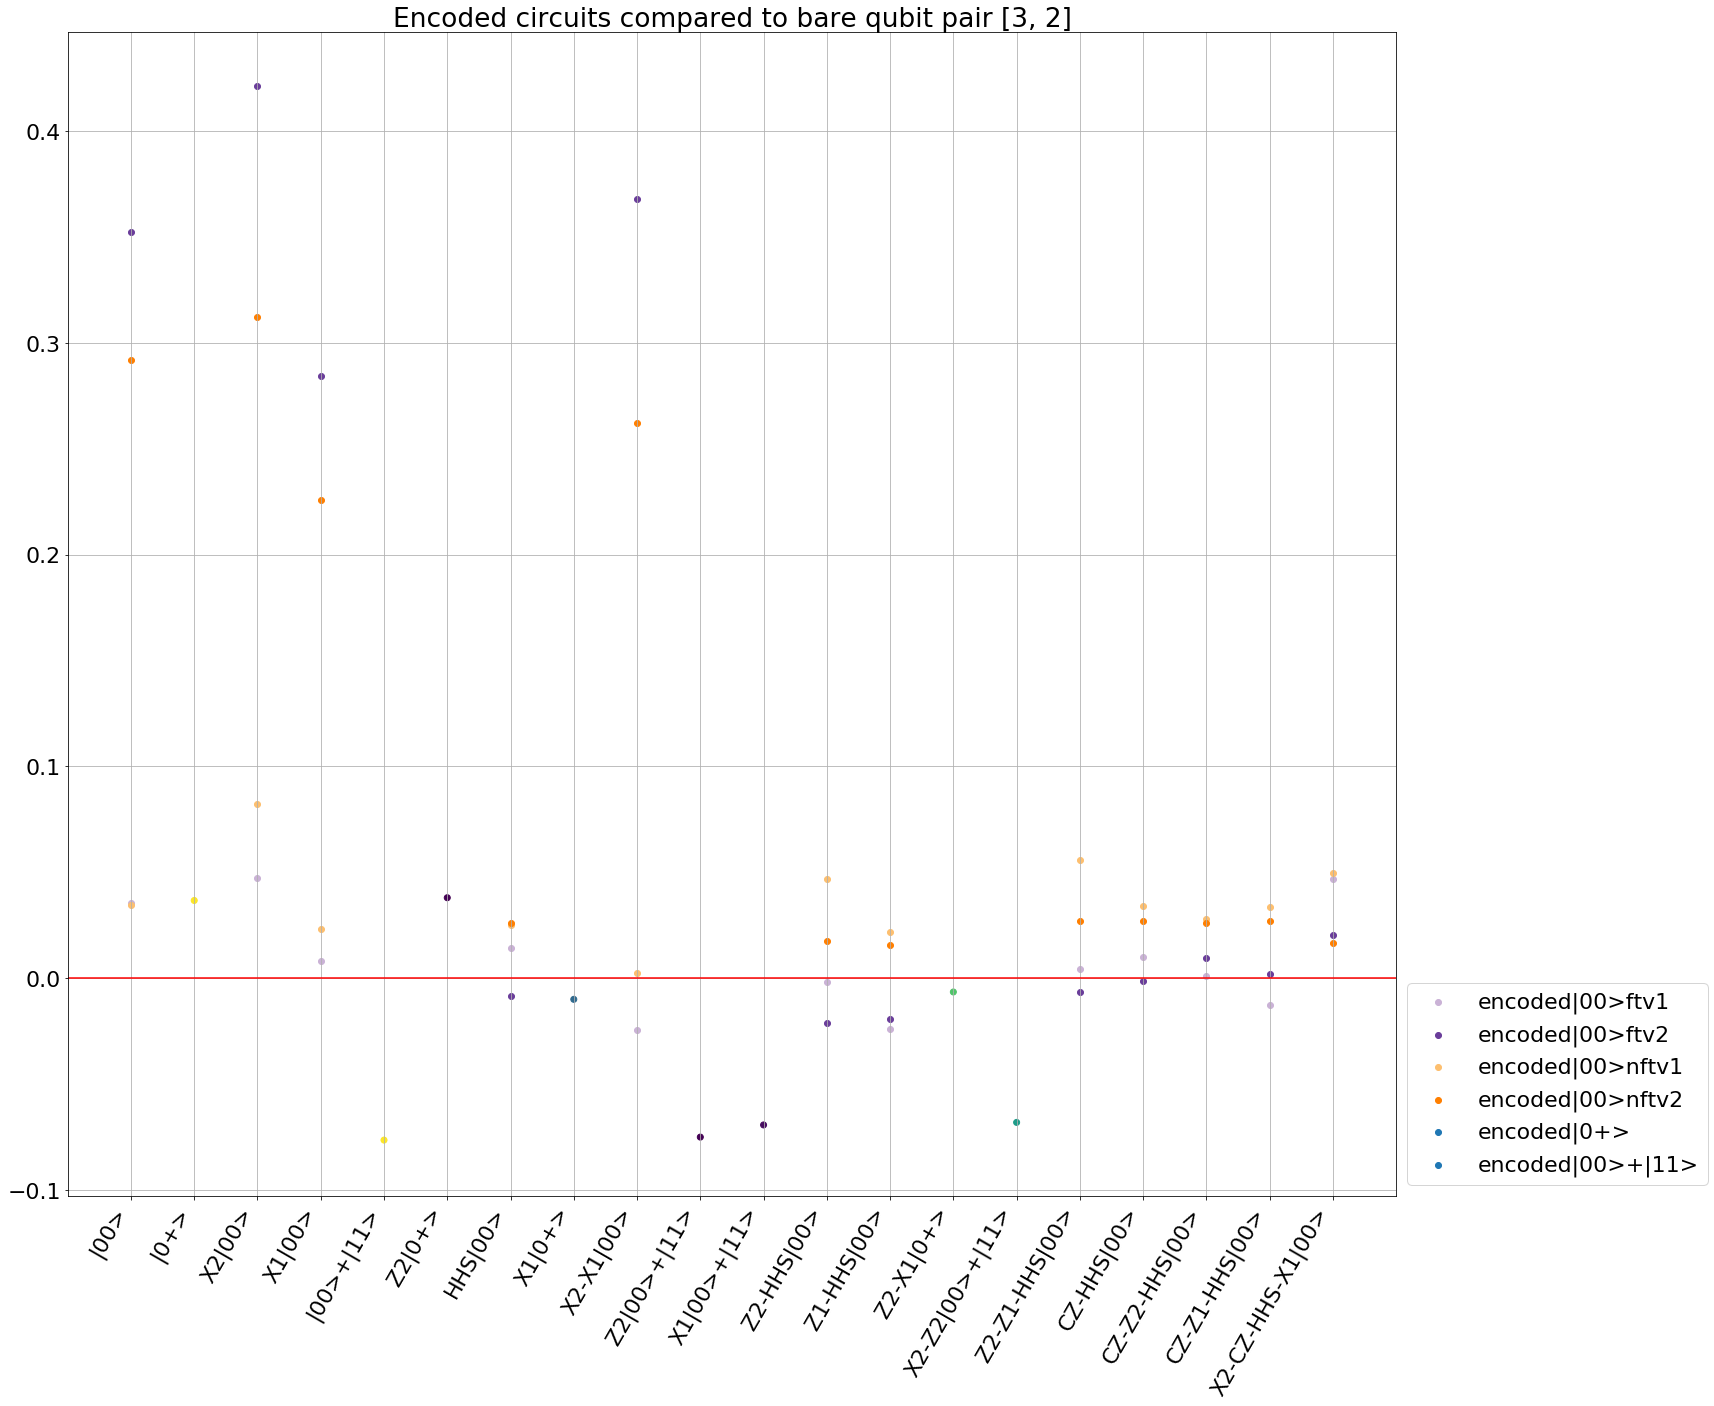

0 834
bare[1, 0] 0.17348734537760416
bare[2, 0] 0.10006968180338542
bare[2, 1] 0.12038930257161458
bare[2, 4] 0.08981119791666667
bare[3, 2] 0.06201578776041666
bare[3, 4] 0.0648101806640625
encoded|00>ftv1 0.00870912503050469
encoded|00>ftv2 0.11670364307948781
encoded|00>nftv1 0.036488473084808536
encoded|00>nftv2 0.1062041760654433
encoded|0+> 0.01453560183812112
encoded|00>+|11> -0.07221282899875331


In [136]:
importlib.reload(exptool)
importlib.reload(plottool)
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plottool.plot_everything_averaged_diff_verif_ftv2('data/Processed_data_verif_nftv2/', save_data_folder_pref=None,
                                 logscaley=False,
                                 bareindex=4,
                                 ci=.99)